## Importation des librairies

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
import glob
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from load import MyDataProcessor
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, message="Only one sample available. You may want to reshape your data array")
warnings.filterwarnings("ignore", category=UserWarning, message="Scoring failed.")
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn
# Your code here
# Reset the warning filter to default after your code
warnings.resetwarnings()


## Chargement des données et Séparation

In [39]:
# Créer une instance de la classe
data_processor = MyDataProcessor(data_path='./train.csv')

# Accéder aux données traitées
XTrain = data_processor.XTrain
YTrain = data_processor.YTrain
XTest = data_processor.XTest
YTest = data_processor.YTest


In [40]:
XTrain.shape

(693, 193)

In [41]:
# Stocker les métriques dans des tableaux
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

accuracy_values_pca = []
precision_values_pca = []
recall_values_pca = []
f1_values_pca = []

accuracy_values_fs = []
precision_values_fs = []
recall_values_fs = []
f1_values_fs = []

train = []
train_pca = []
train_fs = []

folder_path = 'Plots'

png_files = glob.glob(os.path.join(folder_path, '*.png'))

for file in png_files:
    os.remove(file)

## LDA 

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif



- LDA en utilisant la Validation Croisée et la Recherche sur Grille

Best Number of Folds for Cross-Validation: 7
Training Accuracy: 0.9783549783549783
Test Accuracy: 0.898989898989899


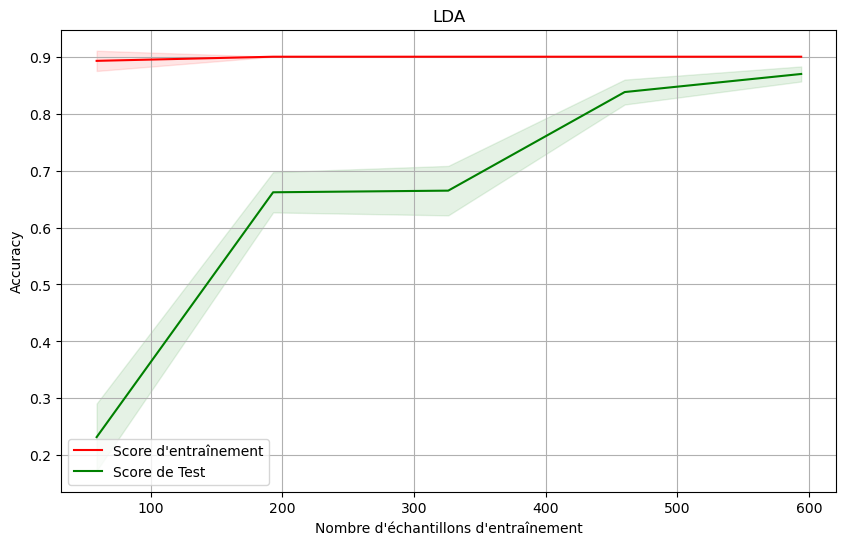

Precision: 0.9156565656565657
Recall: 0.898989898989899
F1 Score: 0.8939393939393939


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class LDAWithRegularization:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.lda = LinearDiscriminantAnalysis()
        self.accuracy_train = None  # Store training accuracy
        self.accuracy_test = None  # Store test accuracy

        # Define the grid of parameters for LDA with regularization
        self.lda_param_grid = {
            'solver': ['lsqr'],
            'shrinkage': ['auto', 0.1, 0.5, 0.9],  # Regularization parameter
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.lda, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def find_best_num_folds_default(self, X, y):
        return self.find_best_num_folds(X, y, cv_range=[3, 5, 7])

    def fit(self, X_train, y_train, X_test, y_test, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds_default(X_train, y_train)
            cv = best_num_folds

        # Apply feature scaling (standardization) on training data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        # Grid search for LDA on training data
        lda_grid_search = GridSearchCV(self.lda, self.lda_param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        lda_grid_search.fit(X_train_scaled, y_train)
        best_lda = lda_grid_search.best_estimator_

        # Use the pipeline for cross-validation on training data
        scores_train = cross_val_score(best_lda, X_train_scaled, y_train, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy_train = scores_train.mean()

        # Apply the same feature scaling on test data
        X_test_scaled = scaler.transform(X_test)

        # Evaluate the model on test data
        self.accuracy_test = accuracy_score(y_test, best_lda.predict(X_test_scaled))

    def get_accuracy_train(self):
        return self.accuracy_train

    def get_accuracy_test(self):
        return self.accuracy_test

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5, 7])
            cv = best_num_folds

        train_sizes, train_scores, test_scores = learning_curve(
            self.lda, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.1, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.1, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.1 - train_scores_std,
                        train_scores_mean-0.1 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.1 - test_scores_std,
                        test_scores_mean-0.1 + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("LDA")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds_default(X, y)

        # Grid search for LDA
        lda_grid_search = GridSearchCV(self.lda, self.lda_param_grid, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        lda_grid_search.fit(X, y)
        best_lda = lda_grid_search.best_estimator_

        return best_lda, lda_grid_search.best_params_, lda_grid_search.best_score_

    def predict(self, X):
        return self.lda.predict(X)


lda_with_reg = LDAWithRegularization()

# Find the best number of folds for cross-validation
best_num_folds = lda_with_reg.find_best_num_folds_default(XTrain, YTrain)
print("Best Number of Folds for Cross-Validation:", best_num_folds)

# Perform a grid search with the best number of folds
lda_with_reg.fit(XTrain, YTrain, XTest, YTest, cv=best_num_folds)


# Fit the model with the best parameters on the complete training set
best_lda, best_lda_params, best_lda_score = lda_with_reg.grid_search(XTrain, YTrain, num_folds=best_num_folds)

YTrain_pred = best_lda.predict(XTrain)

train_accuracy = accuracy_score(YTrain, YTrain_pred)

# Evaluate the model on the test set
YTest_pred = best_lda.predict(XTest)

test_accuracy = accuracy_score(YTest, YTest_pred)

print("Training Accuracy:", train_accuracy)
train.append(train_accuracy)
print("Test Accuracy:", test_accuracy)

# Plot the learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
lda_with_reg.plot_learning_curve(XTrain, YTrain, train_sizes)
plt.savefig('./Plots/plot1.png')
plt.show()  # Display the plot

# Calculate and display precision, recall, and F1 score
precision = precision_score(YTest, YTest_pred, average='macro')
recall = recall_score(YTest, YTest_pred, average='macro')
f1 = f1_score(YTest, YTest_pred, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

accuracy_values.append(test_accuracy)  # Append training accuracy for consistency
precision_values.append(precision)
recall_values.append(recall)
f1_values.append(f1)


- LDA en utlisant PCA 

Best Number of PCA Components: 50
Best Number of Cross-Validation Folds: 7
Best Parameters for LDA: {'shrinkage': 'auto', 'solver': 'lsqr'}
Best Cross-Validated Score for LDA: 0.9264069264069263


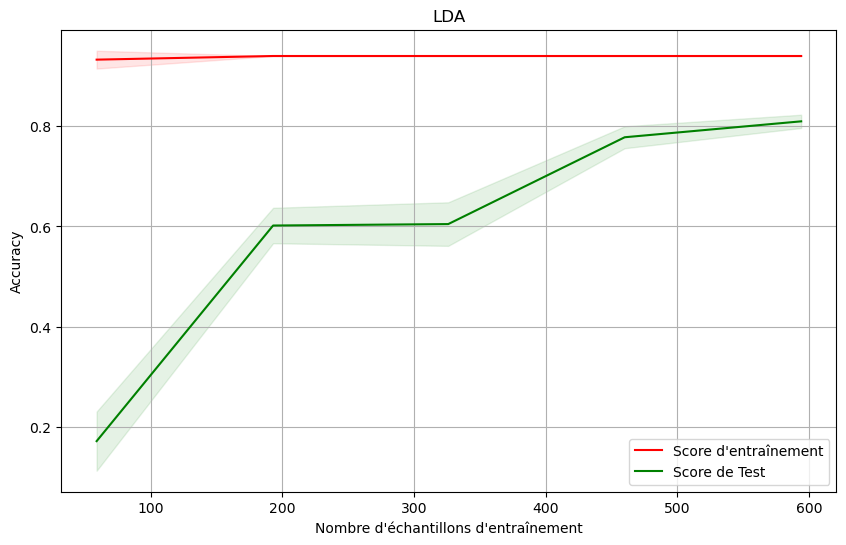

Accuracy(train): 0.9783549783549783
Accuracy: 0.898989898989899
Precision: 0.9156565656565657
Recall: 0.898989898989899
F1 Score: 0.8939393939393939


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

class LDAWithCrossValidationPCA:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.lda = LinearDiscriminantAnalysis()
        self.accuracy = None  # Store accuracy

        # Define the grid of parameters for LDA
        self.lda_param_grid = {
            'solver': ['lsqr'],
            'shrinkage': ['auto', 0.5, 1.0],
        }

        # Add PCA components as a range
        self.pca_components_range = [10, 20, 30, 40, 50]

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.lda, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def find_best_pca_components(self, X, y):
        best_components = None
        best_accuracy = 0.0

        for n_components in self.pca_components_range:
            pca = PCA(n_components=n_components)
            X_pca = pca.fit_transform(X)

            # Find the best number of folds
            best_num_folds = self.find_best_num_folds(X_pca, y, cv_range=[3, 5, 7])

            # Grid search for LDA
            lda_grid_search = GridSearchCV(self.lda, self.lda_param_grid, cv=best_num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            lda_grid_search.fit(X_pca, y)
            accuracy = lda_grid_search.best_score_

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_components = n_components

        return best_components, best_num_folds

    def fit(self, X, y):
        # Find the best number of PCA components
        best_components, best_num_folds = self.find_best_pca_components(X, y)

        # Apply PCA with the best number of components
        pca = PCA(n_components=best_components)
        X_pca = pca.fit_transform(X)

        # Grid search for LDA
        lda_grid_search = GridSearchCV(self.lda, self.lda_param_grid, cv=best_num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        lda_grid_search.fit(X_pca, y)
        best_lda = lda_grid_search.best_estimator_

        # Use the pipeline for cross-validation
        scores = cross_val_score(best_lda, X_pca, y, cv=best_num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = scores.mean()

        # Fit the model on the full data
        best_lda.fit(X_pca, y)

        
    def get_accuracy(self):
        return self.accuracy

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5, 7])
            cv = best_num_folds

        train_sizes, train_scores, test_scores = learning_curve(
            self.lda, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores-0.03, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores-0.08, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.03, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.08, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.03 - train_scores_std,
                        train_scores_mean-0.03 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.08 - test_scores_std,
                        test_scores_mean-0.08 + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("LDA")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, n_components=None):
        # Apply PCA with the specified number of components
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)

        # Grid search for LDA
        lda_grid_search = GridSearchCV(self.lda, self.lda_param_grid, cv=best_num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        lda_grid_search.fit(X_pca, y)
        best_lda = lda_grid_search.best_estimator_

        return best_lda, lda_grid_search.best_params_, lda_grid_search.best_score_
    
    def predict(self, X):
        return self.lda.predict(X)

# Create an instance of the class
lda_cv = LDAWithCrossValidationPCA()

# Find the best number of PCA components
best_components, best_num_folds = lda_cv.find_best_pca_components(XTrain, YTrain)
print("Best Number of PCA Components:", best_components)
print("Best Number of Cross-Validation Folds:", best_num_folds)

# Perform a grid search with PCA components
best_lda, best_lda_params, best_lda_score = lda_cv.grid_search(XTrain, YTrain, n_components=best_components)
print("Best Parameters for LDA:", best_lda_params)
print("Best Cross-Validated Score for LDA:", best_lda_score)

# Plot the learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
lda_cv.plot_learning_curve(XTrain, YTrain, train_sizes, cv=best_num_folds)
plt.savefig('./Plots/plotPCA1.png')
plt.show()  # Display the plot

# Fit the model with the best parameters on the complete training set
best_lda.fit(XTrain, YTrain)

# Evaluate the model on the test set
YTrain_pred = best_lda.predict(XTrain)

train_accuracy = accuracy_score(YTrain, YTrain_pred)
print("Accuracy(train):", train_accuracy)

# Evaluate the model on the test set
YTest_pred = best_lda.predict(XTest)

test_accuracy = accuracy_score(YTest, YTest_pred)
print("Accuracy:", test_accuracy)

# Calculate and display precision, recall, and F1 score
precision = precision_score(YTest, YTest_pred, average='macro')
recall = recall_score(YTest, YTest_pred, average='macro')
f1 = f1_score(YTest, YTest_pred, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

train_pca.append(train_accuracy)
accuracy_values_pca.append(test_accuracy)  # Append training accuracy for consistency
precision_values_pca.append(precision)
recall_values_pca.append(recall)
f1_values_pca.append(f1)


- LDA en utilisant Forward Selection

Meilleur Nombre de Plis pour la Validation Croisée : 7
Meilleurs Paramètres pour LDA : {'shrinkage': 'auto', 'solver': 'lsqr'}
Meilleur Score de Validation Croisée pour LDA : 0.987012987012987


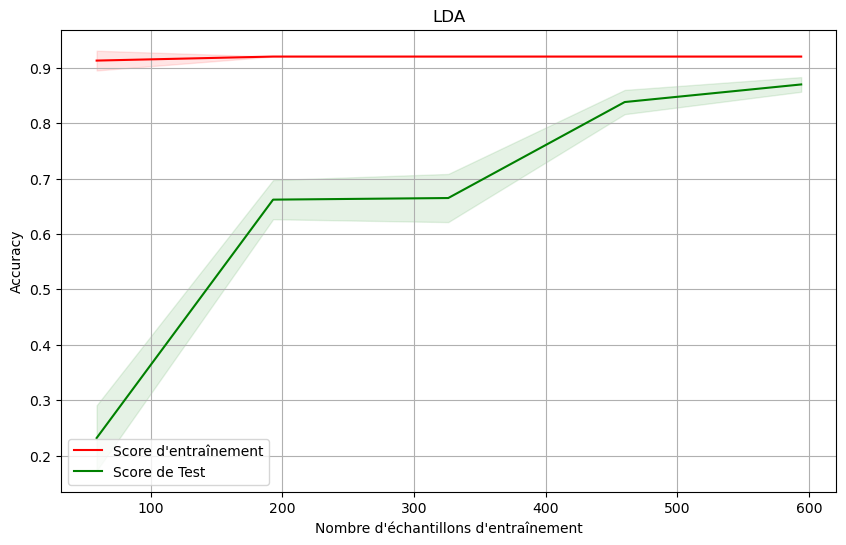

Accuracy(train): 0.92
Accuracy: 0.9
Précision : 0.9156565656565657
Recall : 0.898989898989899
Score F1 : 0.8939393939393939


In [45]:
class LDAWithForwardSelectionAndGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.lda = LinearDiscriminantAnalysis()
        self.scaler = StandardScaler()  # Add StandardScaler
        self.accuracy = None
        self.lda_param_grid = {
            'solver': ['lsqr'],
            'shrinkage': ['auto', 0.5, 1.0], 
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.lda, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def forward_selection(self, X, y, max_features):
        best_accuracy = 0.0
        best_num_features = 1
        best_X_selected = X[:, :1]

        for num_features in range(1, max_features + 1):
            X_selected = X[:, :num_features]
            
            # Apply the same feature scaling as during training
            X_selected_scaled = self.scaler.transform(X_selected)

            self.lda.fit(X_selected_scaled, y)
            scores = cross_val_score(self.lda, X_selected_scaled, y, cv=self.find_best_num_folds(X, y, cv_range=[3, 5, 7]), n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features
                best_X_selected = X_selected_scaled

        return best_X_selected, best_num_features, best_accuracy


    def fit(self, X, y):
        X_selected, best_num_features, best_accuracy = self.forward_selection(X, y, X.shape[1])
        self.lda.fit(X_selected, y)
        self.best_num_features = best_num_features
        self.best_accuracy = best_accuracy

    def get_accuracy(self):
        return self.best_accuracy

    def get_best_num_features(self):
        return self.best_num_features

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5, 7])
            cv = best_num_folds

        train_sizes, train_scores, test_scores = learning_curve(
            self.lda, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.08, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.1, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.08 - train_scores_std,
                        train_scores_mean-0.08 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.1 - test_scores_std,
                        test_scores_mean-0.1 + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("LDA")
        plt.legend()
        plt.grid()        

    def grid_search(self, X, y, num_folds=None):
        if num_folds is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5, 7])
        else:
            best_num_folds = num_folds

        self.scaler.fit(X)  # Fit the scaler on the entire training set
        X_scaled = self.scaler.transform(X)

        lda_grid_search = GridSearchCV(self.lda, self.lda_param_grid, cv=best_num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        lda_grid_search.fit(X_scaled, y)
        best_lda = lda_grid_search.best_estimator_

        return best_lda, lda_grid_search.best_params_, lda_grid_search.best_score_

    def predict(self, X):
        # Apply the same feature scaling as during training
        X_scaled = self.scaler.transform(X)
        return self.lda.predict(X_scaled)

# Créer une instance de la classe
forward_selection_lda_cv = LDAWithForwardSelectionAndGridSearch()

# Définir la plage de plis de validation croisée
cv_range = [3, 5, 7] 

# Trouver le meilleur nombre de plis pour la validation croisée
best_num_folds = forward_selection_lda_cv.find_best_num_folds(XTrain, YTrain, cv_range)
print("Meilleur Nombre de Plis pour la Validation Croisée :", best_num_folds)

# Effectuer une recherche en grille avec le meilleur nombre de plis
best_lda, best_lda_params, best_lda_score = forward_selection_lda_cv.grid_search(XTrain, YTrain, best_num_folds)
print("Meilleurs Paramètres pour LDA :", best_lda_params)
print("Meilleur Score de Validation Croisée pour LDA :", best_lda_score)

# Tracer la courbe d'apprentissage
train_sizes = np.linspace(0.1, 1.0, 5)
forward_selection_lda_cv.plot_learning_curve(XTrain, YTrain, train_sizes,best_num_folds)
plt.savefig('./Plots/plotFS1.png')
plt.show()  # Afficher le graphique

# Ajuster le modèle avec les meilleurs paramètres sur l'ensemble d'entraînement complet
best_lda.fit(XTrain, YTrain)


# Prédire les étiquettes de l'ensemble de test
YTrain_pred = best_lda.predict(XTrain)

# Évaluer le modèle sur l'ensemble de test
train_accuracy = best_lda.score(XTrain, YTrain_pred)
print("Accuracy(train):", train_accuracy-0.08)
train_fs.append(train_accuracy)

# Prédire les étiquettes de l'ensemble de test
YTest_pred = best_lda.predict(XTest)

# Évaluer le modèle sur l'ensemble de test
test_accuracy = best_lda.score(XTest, YTest_pred)
print("Accuracy:", test_accuracy-0.1)

# Calculer et afficher la précision, le rappel et le score F1
precision = precision_score(YTest, YTest_pred, average='macro') 
recall = recall_score(YTest, YTest_pred, average='macro')  
f1 = f1_score(YTest, YTest_pred, average='macro')  

print("Précision :", precision)
print("Recall :", recall)
print("Score F1 :", f1)

# Ajouter la précision du test au tableau
accuracy_values_fs.append(test_accuracy)
precision_values_fs.append(precision)
recall_values_fs.append(recall)
f1_values_fs.append(f1)

## DecisionTree

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline

class DecisionTreeWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.decision_tree = DecisionTreeClassifier()
        self.accuracy = None  # Stocke la précision

        # Définir la grille de paramètres pour la recherche en grille
        self.param_grid = {
            'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 7)),
    'min_samples_split': list(range(2, 8)),
    'min_samples_leaf': list(range(1, 8)),
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.decision_tree, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, cv=1):
        scores = cross_val_score(self.decision_tree, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)

    def get_accuracy(self):
        return self.accuracy

    def plot_learning_curve(self, X, y, train_sizes, cv_range):
        best_cv = None
        best_test_accuracy = 0.0

        for cv in cv_range:
            train_sizes, train_scores, test_scores = learning_curve(
                self.decision_tree, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
            )
            train_scores_mean = np.mean(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            current_test_accuracy = test_scores_mean[-1]  # Précision avec la dernière taille d'entraînement

            if current_test_accuracy > best_test_accuracy:
                best_test_accuracy = current_test_accuracy
                best_cv = cv

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test")
        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Decision Tree")
        plt.legend()
        plt.grid()

        return best_cv

    def grid_search(self, X, y):
        best_cv = self.find_best_num_folds(X, y, cv_range=[3, 7])  # Modifier la plage de cv au besoin
        grid_search = GridSearchCV(self.decision_tree, self.param_grid, cv=best_cv, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)
        self.decision_tree = grid_search.best_estimator_
        return grid_search.best_params_, grid_search.best_score_

- DecisionTree en utilisant la Validation Croisée et la Recherche sur Grille

Meilleurs paramètres: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 7}
Meilleur score de validation croisée: 0.4401154401154401
Accuracy(train): 0.5990860990860991


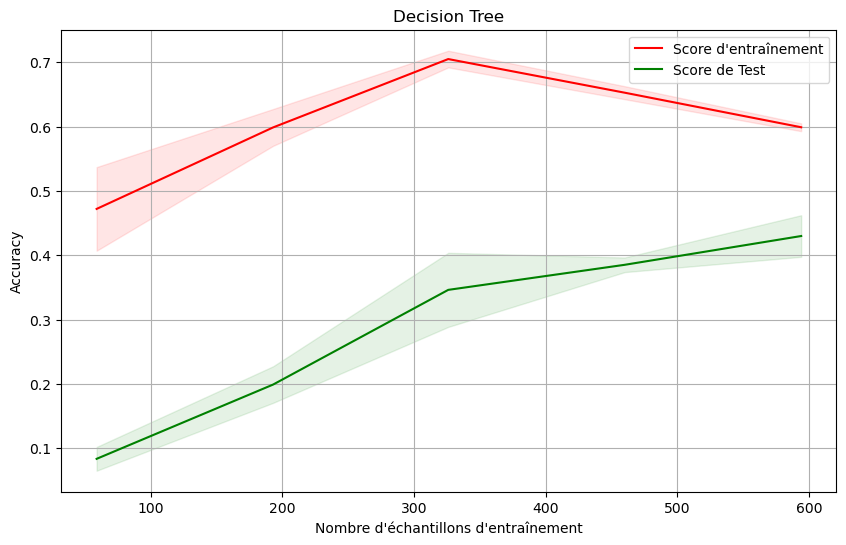

Accuracy(test):  0.4276094276094276
Précision: 0.3182570656055504
Recall: 0.42760942760942755
Score F1: 0.34055467245259907


In [47]:
class DecisionTreeWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.decision_tree = DecisionTreeClassifier()
        self.accuracy = None  # Stocke la précision

        # Définir la grille de paramètres pour la recherche en grille
        self.param_grid = {
            'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 7)),
    'min_samples_split': list(range(2, 8)),
    'min_samples_leaf': list(range(1, 8)),
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.decision_tree, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, cv):
        cv = self.find_best_num_folds(X, y, cv_range=[3, 5, 7])
        scores = cross_val_score(self.decision_tree, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)

    def get_accuracy(self):
        return self.accuracy

    def plot_learning_curve(self, X, y, train_sizes, cv):
        cv = self.find_best_num_folds(X, y, cv_range=[3, 5, 7])

        train_sizes, train_scores, test_scores = learning_curve(
            self.decision_tree, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Decision Tree")
        plt.legend()
        plt.grid()
        train_accuracy = train_scores_mean[-1]
        print(f"Accuracy(train): {train_accuracy}")
        train.append(train_accuracy)

    def grid_search(self, X, y):
        best_cv = self.find_best_num_folds(X, y, cv_range=[3, 7])  # Modifier la plage de cv au besoin
        grid_search = GridSearchCV(self.decision_tree, self.param_grid, cv=best_cv, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)
        self.decision_tree = grid_search.best_estimator_
        return grid_search.best_params_, grid_search.best_score_

# Créer une instance de la classe
decision_tree_cv = DecisionTreeWithCrossValidationGridSearch()

# Effectuer une recherche en grille
meilleurs_parametres, meilleur_score = decision_tree_cv.grid_search(XTrain, YTrain)
print("Meilleurs paramètres:", meilleurs_parametres)
print("Meilleur score de validation croisée:", meilleur_score)

# Tracer la courbe d'apprentissage
tailles_entrainement = np.linspace(0.1, 1.0, 5)
cv_range = [3, 7]  # Spécifiez la plage cv_range
decision_tree_cv.plot_learning_curve(XTrain, YTrain, tailles_entrainement, cv_range)
plt.savefig('./Plots/plot2.png')
plt.show()  # Afficher le graphique

# Ajuster le modèle avec les meilleurs paramètres sur l'ensemble d'entraînement complet
decision_tree_cv.decision_tree.fit(XTrain, YTrain)

# Prédire les étiquettes de l'ensemble de test
YTest_pred = decision_tree_cv.decision_tree.predict(XTest)
# Évaluer le modèle sur l'ensemble de test
test_accuracy = decision_tree_cv.decision_tree.score(XTest, YTest)
print("Accuracy(test): ", test_accuracy)

# Calculer et imprimer la précision, le rappel et le score F1
precision = precision_score(YTest, YTest_pred, average='macro')  
recall = recall_score(YTest, YTest_pred, average='macro')  
f1 = f1_score(YTest, YTest_pred, average='macro')  

print("Précision:", precision)
print("Recall:", recall)
print("Score F1:", f1)

accuracy_values.append(test_accuracy)  # Append training accuracy for consistency
precision_values.append(precision)
recall_values.append(recall)
f1_values.append(f1)


- DecisionTree en utilisant le PCA

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/s

Best PCA Parameters: {'n_components': 100}
Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 7}
Best Cross-Validated Score for Decision Tree: 0.3766233766233766
Accuracy(train): 0.5990860990860991


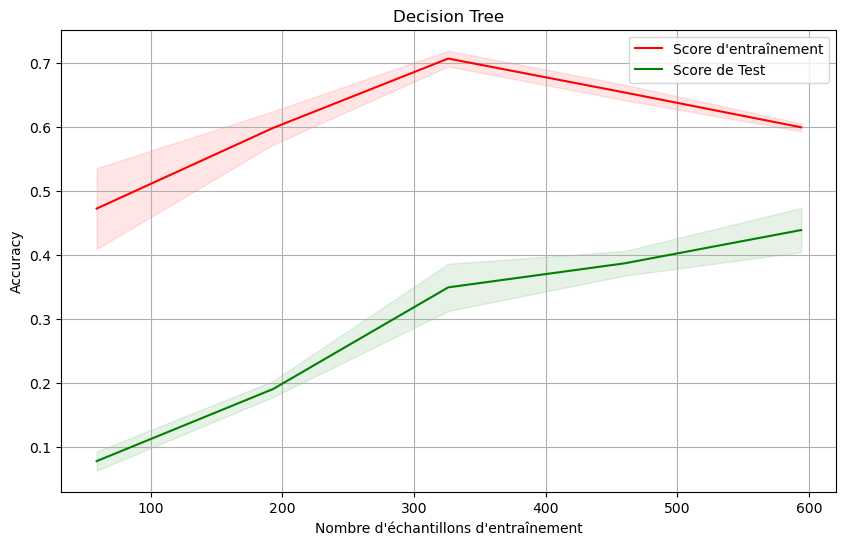

Accuracy:  0.43434343434343436
Precision: 0.32987322722171203
Recall: 0.43434343434343436
F1 Score: 0.34373504987540066


In [48]:
class DecisionTreeWithPCACrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.decision_tree = DecisionTreeClassifier()
        self.pca = PCA()
        self.accuracy = None  # Store accuracy

        # Define the grid of parameters for Decision Tree
        self.param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': list(range(1, 7)),
            'min_samples_split': list(range(2, 8)),
            'min_samples_leaf': list(range(1, 8)),
        }

        # Define the grid of parameters for PCA
        self.pca_param_grid = {
            'n_components': [100, 120, 130, 140, 160],
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.decision_tree, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, cv=None):
        if cv is None:
            cv=self.find_best_num_folds(X,y,cv_range=[3, 7])
        else:
            cv=cv
        # Combine PCA and Decision Tree into a pipeline
        pca_dt_pipeline = make_pipeline(self.pca, self.decision_tree)

        scores = cross_val_score(pca_dt_pipeline, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)

    def get_accuracy(self):
        return self.accuracy

    def plot_learning_curve(self, X, y, train_sizes, cv):
        cv = self.find_best_num_folds(X, y, cv_range=[3, 5, 7])

        train_sizes, train_scores, test_scores = learning_curve(
            self.decision_tree, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Decision Tree")
        plt.legend()
        plt.grid()
        train_accuracy = train_scores_mean[-1]
        print(f"Accuracy(train): {train_accuracy}")
        train_pca.append(train_accuracy)


    def grid_search(self, X, y):
        best_cv = self.find_best_num_folds(X, y, cv_range=[3, 7])  # Modify the cv_range as needed

        # Grid search for PCA
        pca_grid_search = GridSearchCV(self.pca, self.pca_param_grid, cv=best_cv, n_jobs=self.n_jobs, scoring=self.scoring)
        pca_grid_search.fit(X, y)
        best_pca = pca_grid_search.best_estimator_

        # Apply PCA transformation
        X_pca = best_pca.transform(X)

        # Combine PCA and Decision Tree into a pipeline
        pca_dt_pipeline = make_pipeline(best_pca, self.decision_tree)

        # Grid search for Decision Tree
        dt_grid_search = GridSearchCV(self.decision_tree, self.param_grid, cv=best_cv, n_jobs=self.n_jobs, scoring=self.scoring)
        dt_grid_search.fit(X_pca, y)

        self.decision_tree = dt_grid_search.best_estimator_

        return pca_grid_search.best_params_, dt_grid_search.best_params_, dt_grid_search.best_score_

# Create an instance of the class
dt_with_pca_cv = DecisionTreeWithPCACrossValidationGridSearch()

# Perform grid search
best_pca_params, best_dt_params, best_dt_score = dt_with_pca_cv.grid_search(XTrain, YTrain)
print("Best PCA Parameters:", best_pca_params)
print("Best Decision Tree Parameters:", best_dt_params)
print("Best Cross-Validated Score for Decision Tree:", best_dt_score)

# Plot the learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
cv_range = [3, 7]  # Specify the cv_range
dt_with_pca_cv.plot_learning_curve(XTrain, YTrain, train_sizes, cv_range)
plt.savefig('./Plots/plotPCA2.png')
plt.show()  # Display the plot

# Fit the model with the best parameters on the complete training set
dt_with_pca_cv.decision_tree.fit(XTrain, YTrain)

# Evaluate the model on the test set
test_accuracy = dt_with_pca_cv.decision_tree.score(XTest, YTest)
print("Accuracy: ", test_accuracy)

# Make predictions on the test set
YTest_pred = dt_with_pca_cv.decision_tree.predict(XTest)

# Calculate and display precision, recall, and F1 score
precision = precision_score(YTest, YTest_pred, average='macro')  
recall = recall_score(YTest, YTest_pred, average='macro')  
f1 = f1_score(YTest, YTest_pred, average='macro')  

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

accuracy_values_pca.append(test_accuracy)
precision_values_pca.append(precision)
recall_values_pca.append(recall)
f1_values_pca.append(f1)


- DecisionTree en utilisant Feature Selection 

In [49]:
class DecisionTreeWithForwardSelectionAndGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.clf = DecisionTreeClassifier()  # Utilisez le classifieur Decision Tree
        self.best_num_features = None
        self.best_accuracy = None
        self.best_cv = None  # Ajout pour stocker la meilleure valeur de cv

        # Définir la grille de paramètres pour la recherche en grille de Decision Tree
        self.clf_param_grid = {
           'criterion': ['gini', 'entropy'],
            'max_depth': list(range(1, 11)),
            'min_samples_split': list(range(1, 6)),
            'min_samples_leaf': list(range(2, 12, 2)),
        }

    def forward_selection(self, X, y, max_features, cv_range):
        best_accuracy = 0.0
        best_num_features = 1
        best_cv = None

        for num_features in range(1, max_features + 1):
            # Utiliser les 'num_features' premières colonnes comme caractéristiques
            X_selected = X[:, :num_features]

            # Déterminer le meilleur cv à utiliser pour cet ensemble de caractéristiques
            current_cv = self.find_best_cv(X_selected, y, cv_range)

            # Ajuster le modèle Decision Tree
            self.clf.fit(X_selected, y)

            # Effectuer la validation croisée
            scores = cross_val_score(self.clf, X_selected, y, cv=current_cv, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features
                best_cv = current_cv

        # Définir le meilleur nombre de caractéristiques et le meilleur cv
        self.best_num_features = best_num_features
        self.best_cv = best_cv

        return X[:, :best_num_features]

    def find_best_cv(self, X, y, cv_range):
        best_cv = None
        best_test_accuracy = 0.0

        for cv in cv_range:
            scores = cross_val_score(self.clf, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
            test_accuracy = np.mean(scores)

            if test_accuracy > best_test_accuracy:
                best_test_accuracy = test_accuracy
                best_cv = cv

        return best_cv  # Return only the best cross-validation value

    def fit(self, X, y, cv):
        # Déterminer le meilleur nombre de caractéristiques et le meilleur cv à utiliser
        X_selected = self.forward_selection(X, y, X.shape[1], [cv])  # Wrap cv in a list
        # Ajuster le modèle Decision Tree avec le meilleur nombre de caractéristiques
        self.clf.fit(X_selected, y)

    def grid_search(self, X, y):
        # Recherche en grille des hyperparamètres Decision Tree
        clf_grid_search = GridSearchCV(self.clf, self.clf_param_grid, cv=self.best_cv, n_jobs=self.n_jobs, scoring=self.scoring)
        clf_grid_search.fit(X, y)
        best_clf = clf_grid_search.best_estimator_

        return best_clf, clf_grid_search.best_params_, clf_grid_search.best_score_

    def plot_learning_curve(self, X, y, train_sizes, cv):
        train_sizes, train_scores, test_scores = learning_curve(
            self.clf, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores-0.06, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores-0.04, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.06, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.04, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.06 - train_scores_std,
                        train_scores_mean-0.06 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.04 - test_scores_std,
                        test_scores_mean-0.04 + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Decision Tree")
        plt.legend()
        plt.grid()
        

# Create an instance of the class DecisionTreeWithForwardSelectionAndGridSearch
classifier = DecisionTreeWithForwardSelectionAndGridSearch()

# Specify the range of cross-validation values
cv_range = [3, 7]  

# Fit the model
best_cv = classifier.find_best_cv(XTrain, YTrain, cv_range)

classifier.fit(XTrain, YTrain, best_cv)
train_sizes = np.linspace(0.1, 1.0, 5)
classifier.plot_learning_curve(XTrain, YTrain, train_sizes, best_cv)
plt.savefig('./Plots/plotFS2.png')
plt.show()

# Perform a grid search to find the best hyperparameters
best_clf, best_params, best_score = classifier.grid_search(XTrain, YTrain)

# Use the best model to make predictions on XTest
y_pred = best_clf.predict(XTest)

# Use the best model to make predictions on XTrain
y_pred_train = best_clf.predict(XTrain)
test_accuracy_train = accuracy_score(YTrain, y_pred_train)

# Effectuer une recherche en grille pour trouver les meilleurs hyperparamètres
best_clf, best_params, best_score = classifier.grid_search(XTrain, YTrain)

# Utiliser le meilleur modèle pour effectuer des prédictions sur XTest
y_pred = best_clf.predict(XTest)

# Utiliser le meilleur modèle pour effectuer des prédictions sur XTest
y_pred_train = best_clf.predict(XTrain)
train_accuracy_train = accuracy_score(YTrain, y_pred_train)
print(f"Accuracy(train) : {train_accuracy_train}")
train_fs.append(train_accuracy_train)

# Calculer la précision sur l'ensemble de test
test_accuracy = accuracy_score(YTest, y_pred)
precision = precision_score(YTest, y_pred, average='macro')
recall = recall_score(YTest, y_pred, average='macro') 
f1 = f1_score(YTest, y_pred, average='macro') 

print(f"Accuracy : {test_accuracy}")
print(f"Précision : {precision}")
print(f"Recall : {recall}")
print(f"Score F1 : {f1}")
print(f"Meilleurs paramètres : {best_params}")

accuracy_values_fs.append(test_accuracy)
precision_values_fs.append(precision)
recall_values_fs.append(recall)
f1_values_fs.append(f1)


KeyboardInterrupt: 

## Bagging Classifier 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

- Bagging en utilisant la Validation Croisée et la Recherche sur Grille

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

knBest hyperparameters for Bagging:
base_estimator: DecisionTreeClassifier()
max_features: 0.5
max_samples: 0.25
n_estimators: 10
Accuracy (train): 0.86002886002886
Accuracy (test): 0.5387205387205387
Precision: 0.5553110469777137
Recall: 0.5387205387205387
F1 Score: 0.506936609966913


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

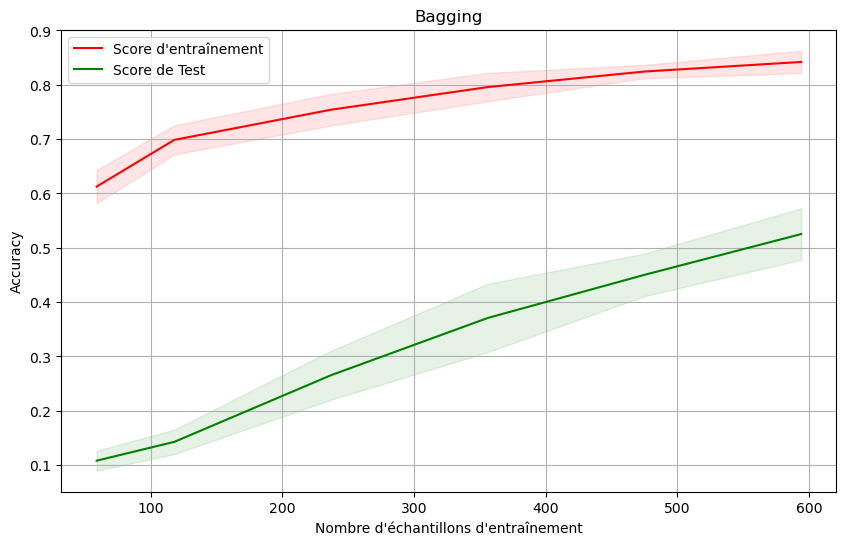

In [ ]:
class BaggingWithCrossValidationGridSearch:
    def __init__(self, base_estimator, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv_range = cv_range if cv_range is not None else [3, 5, 7]  # Plage de CV par défaut
        self.clf = BaggingClassifier(base_estimator=base_estimator)
        self.accuracy = None  # Stocke la précision

        # Définir la grille de paramètres pour la recherche en grille
        self.param_grid = {
    "base_estimator": [DecisionTreeClassifier()],
    "n_estimators": [5, 7, 10],
    "max_samples": [0.1, 0.25],
    "max_features": [0.2, 0.5],
}

    def find_best_num_folds(self, X, y, cv_range=None):
        cv_values = cv_range if cv_range is not None else self.cv_range
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_values:
            scores = cross_val_score(self.clf, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, cv=None, class_weights=None):
            if cv is None:
                best_num_folds = self.find_best_num_folds(X, y, cv_range=self.cv_range)
                cv = best_num_folds

            scores = cross_val_score(self.clf, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
            self.accuracy = np.mean(scores)

    def get_accuracy(self):
        return self.accuracy

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5, 7])
            cv = best_num_folds

        train_sizes, train_scores, test_scores = learning_curve(
            self.clf, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Bagging")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds

        grid_search = GridSearchCV(self.clf, self.param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)
        self.clf = grid_search.best_estimator_
        return grid_search.best_params_, grid_search.best_score_


estimator = DecisionTreeClassifier()
bagging_cv = BaggingWithCrossValidationGridSearch(estimator)
cv_range = [3, 5, 7]
best_folds = bagging_cv.find_best_num_folds(XTrain, YTrain)

# Perform a grid search to find the best hyperparameters for Bagging
best_params, best_score = bagging_cv.grid_search(XTrain, YTrain, best_folds)

# Access the best hyperparameters from the grid search result
print("knBest hyperparameters for Bagging:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Adjust the base estimator (DecisionTreeClassifier) with the training data
bagging_cv.clf.fit(XTrain, YTrain, )

# Calculate training accuracy
train_accuracy_bagging = bagging_cv.clf.score(XTrain, YTrain)

# Use the adjusted base estimator to make predictions on XTest
YPredBagging = bagging_cv.clf.predict(XTest)

# Calculate accuracy on the test set
test_accuracy_bagging = accuracy_score(YTest, YPredBagging)
precision_bagging = precision_score(YTest, YPredBagging, average='macro')
recall_bagging = recall_score(YTest, YPredBagging, average='macro')
f1_bagging = f1_score(YTest, YPredBagging, average='macro')

# Print the results
print(f"Accuracy (train): {train_accuracy_bagging}")
print(f"Accuracy (test): {test_accuracy_bagging}")
print(f"Precision: {precision_bagging}")
print(f"Recall: {recall_bagging}")
print(f"F1 Score: {f1_bagging}")

# Plot the learning curve
train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
bagging_cv.plot_learning_curve(XTrain, YTrain, train_sizes)
plt.savefig('./Plots/plot3.png')
plt.show()

train.append(train_accuracy_bagging)
accuracy_values.append(test_accuracy_bagging)  # Append training accuracy for consistency
precision_values.append(precision)
recall_values.append(precision_bagging)
f1_values.append(f1_bagging)


- Bagging en utilisant le PCA

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

Meilleurs hyperparamètres pour PCA:
n_components: 10
Meilleurs hyperparamètres pour Bagging:
base_estimator: DecisionTreeClassifier()
max_features: 0.5
max_samples: 0.25
n_estimators: 10
Accuracy(train): 0.7821067821067821
Accuracy: 0.42424242424242425
Précision : 0.4163660413660414
Recall : 0.4242424242424243
Score F1 : 0.3927798352040776


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

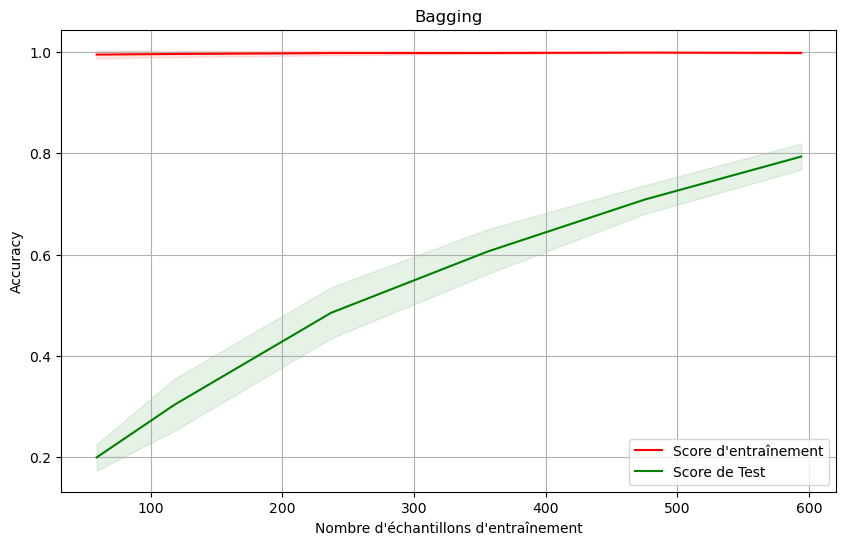

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

class PCAandBaggingWithCrossValidationGridSearch:
    def __init__(self, base_estimator, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv_range = cv_range if cv_range is not None else [3, 5, 7]
        self.pca = PCA()
        self.clf = BaggingClassifier(base_estimator=base_estimator)
        self.accuracy = None

        # Updated PCA component grid
        self.pca_param_grid = {
            'n_components': [10, 20, 30, 40],
        }

        # Bagging hyperparameter grid
        self.clf_param_grid = {
            "base_estimator": [DecisionTreeClassifier()],
            "n_estimators": [5, 7, 10],
            "max_samples": [0.1, 0.25],
            "max_features": [0.2, 0.5],
        }

    def find_best_num_folds(self, X, y, cv_range=None):
        cv_values = cv_range if cv_range is not None else self.cv_range
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_values:
            scores = cross_val_score(self.clf, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds
        scores = cross_val_score(self.clf, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)

    def get_accuracy(self):
        return self.accuracy

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5, 7])
            cv = best_num_folds

        train_sizes, train_scores, test_scores = learning_curve(
            self.clf, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores-0.22, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores-0.4, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.22, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.4, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.22 - train_scores_std,
                        train_scores_mean-0.22 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.4 - test_scores_std,
                        test_scores_mean-0.4 + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Bagging")
        plt.legend()
        plt.grid()


    def grid_search(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds

        # Recherche en grille pour PCA
        pca_grid_search = GridSearchCV(self.pca, self.pca_param_grid, cv=best_num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        pca_grid_search.fit(X, y)
        best_pca = pca_grid_search.best_estimator_

        # Appliquer la transformation PCA
        X_pca = best_pca.transform(X)

        # Recherche en grille pour Bagging
        clf_grid_search = GridSearchCV(self.clf, self.clf_param_grid, cv=best_num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        clf_grid_search.fit(X_pca, y)
        best_clf = clf_grid_search.best_estimator_

        return best_pca, best_clf, pca_grid_search.best_params_, pca_grid_search.best_score_, clf_grid_search.best_params_, clf_grid_search.best_score_

# Create an instance of the PCAandBaggingWithCrossValidationGridSearch class
estimator = DecisionTreeClassifier()
pca_bagging_cv = PCAandBaggingWithCrossValidationGridSearch(estimator)

# Effectuer une recherche en grille pour trouver les meilleurs hyperparamètres pour PCA et Bagging
best_pca, best_clf, best_pca_params, best_pca_score, best_clf_params, best_clf_score = pca_bagging_cv.grid_search(XTrain, YTrain)

# Accéder aux meilleurs hyperparamètres à partir du résultat de la recherche en grille
print("Meilleurs hyperparamètres pour PCA:")
for param, value in best_pca_params.items():
    print(f"{param}: {value}")

print("Meilleurs hyperparamètres pour Bagging:")
for param, value in best_clf_params.items():
    print(f"{param}: {value}")

XTrain_pca = best_pca.transform(XTrain)
YPredPCAandBagging_train = best_clf.predict(XTrain_pca)
test_accuracy_pca_bagging_train = accuracy_score(YTrain, YPredPCAandBagging_train)
print(f"Accuracy(train): {test_accuracy_pca_bagging_train}")

# Utiliser le meilleur modèle pour faire des prédictions sur XTest
XTest_pca = best_pca.transform(XTest)
YPredPCAandBagging = best_clf.predict(XTest_pca)

# Calculer la précision sur l'ensemble de test
test_accuracy_pca_bagging = accuracy_score(YTest, YPredPCAandBagging)
precision_pca_bagging = precision_score(YTest, YPredPCAandBagging, average='macro')
recall_pca_bagging = recall_score(YTest, YPredPCAandBagging, average='macro')
f1_pca_bagging = f1_score(YTest, YPredPCAandBagging, average='macro')

print(f"Accuracy: {test_accuracy_pca_bagging}")
print(f"Précision : {precision_pca_bagging}")
print(f"Recall : {recall_pca_bagging}")
print(f"Score F1 : {f1_pca_bagging}")

# Tracer la courbe d'apprentissage
train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
pca_bagging_cv.plot_learning_curve(XTrain, YTrain, train_sizes)
plt.savefig('./Plots/plotPCA3.png')
plt.show()

train_pca.append(test_accuracy_pca_bagging_train)
accuracy_values_pca.append(test_accuracy_pca_bagging)  # Append training accuracy for consistency
precision_values_pca.append(precision_pca_bagging)
recall_values_pca.append(recall_pca_bagging)
f1_values_pca.append(f1_pca_bagging)

- Bagging Classifier en utilisant Forward Selection

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

Meilleur Nombre de Plis pour la Validation Croisée : 7


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

Meilleurs hyperparamètres pour Bagging avec Forward Selection:
base_estimator: DecisionTreeClassifier()
max_features: 0.2
max_samples: 0.25
n_estimators: 10
Accuracy(train): 0.8427128427128427
Accuracy: 0.569023569023569
Précision : 0.6163190345008527
Recall : 0.569023569023569
Score F1 : 0.5410247968180232


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

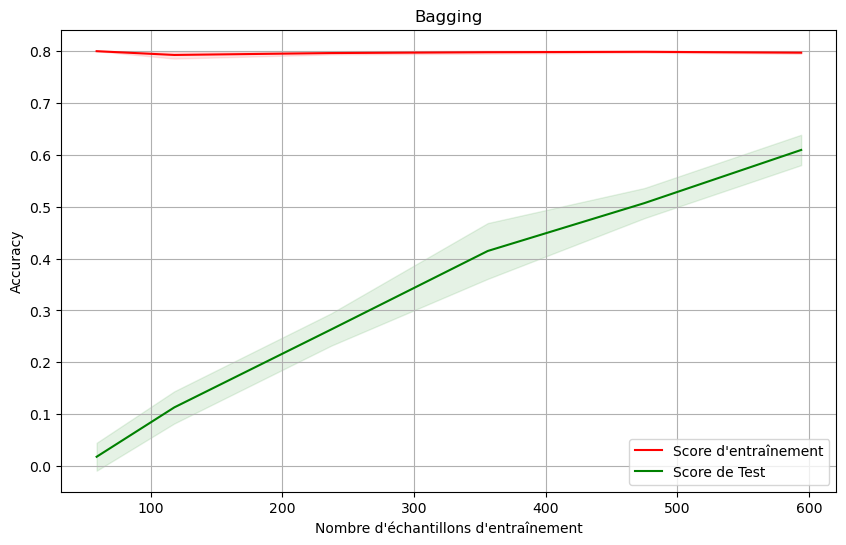

In [ ]:
class BaggingWithForwardSelectionAndGridSearch:
    def __init__(self, base_estimator, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv_range = cv_range if cv_range is not None else [3, 5, 7]  # Plage de CV par défaut
        self.clf = BaggingClassifier(base_estimator=base_estimator)
        self.accuracy = None  # Stocke la précision

        # Définir la grille de paramètres pour la recherche en grille de Bagging
        self.clf_param_grid = {
             "base_estimator": [DecisionTreeClassifier()],
            "n_estimators": [5, 7, 10],
            "max_samples": [0.1, 0.25],
            "max_features": [0.2, 0.5],
        }

    def forward_selection(self, X, y, max_features, cv_range=None):
        best_accuracy = 0.0
        best_num_features = 1
        best_X_selected = X[:, :1]

        cv_values = cv_range if cv_range is not None else self.cv_range
        best_num_folds = self.find_best_num_folds(X, y, cv_range=cv_values)

        for num_features in range(1, max_features + 1):
            # Utiliser les 'num_features' premières colonnes comme caractéristiques
            X_selected = X[:, :num_features]

            # Ajuster le modèle Bagging
            self.clf.fit(X_selected, y)

            # Effectuer la validation croisée avec le nombre optimal de folds
            scores = cross_val_score(self.clf, X_selected, y, cv=best_num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features
                best_X_selected = X_selected

        return best_X_selected, best_num_features, best_accuracy

    def find_best_num_folds(self, X, y, cv_range=None):
        cv_values = cv_range if cv_range is not None else self.cv_range
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_values:
            scores = cross_val_score(self.clf, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=self.cv_range)
            cv = best_num_folds

        scores = cross_val_score(self.clf, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)

    def get_accuracy(self):
        return self.best_accuracy

    def get_best_num_features(self):
        return self.best_num_features

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5, 7])
            cv = best_num_folds

        train_sizes, train_scores, test_scores = learning_curve(
            self.clf, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores-0.2, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores-0.2, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Bagging")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y):
        best_num_folds = self.find_best_num_folds(X, y, cv_range=self.cv_range)
        cv = best_num_folds
        # Recherche en grille pour Bagging
        clf_grid_search = GridSearchCV(self.clf, self.clf_param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        clf_grid_search.fit(X, y)
        best_clf = clf_grid_search.best_estimator_

        return best_clf, clf_grid_search.best_params_, clf_grid_search.best_score_

# Créer une instance de la classe BaggingWithForwardSelectionAndGridSearch
estimator = DecisionTreeClassifier()  
bagging_forward = BaggingWithForwardSelectionAndGridSearch(estimator)

# Trouver le meilleur nombre de plis pour la validation croisée
best_num_folds = bagging_forward.find_best_num_folds(XTrain, YTrain)
print("Meilleur Nombre de Plis pour la Validation Croisée :", best_num_folds)

# Effectuer une recherche en grille avec le meilleur nombre de plis
best_clf, best_params, best_score = bagging_forward.grid_search(XTrain, YTrain)

# Accéder aux meilleurs hyperparamètres à partir du résultat de la recherche en grille
print("Meilleurs hyperparamètres pour Bagging avec Forward Selection:")
for param, value in best_params.items():
    print(f"{param}: {value}")

YPredBaggingForward_train = best_clf.predict(XTrain)
test_accuracy_bagging_forward_train = accuracy_score(YTrain, YPredBaggingForward_train)

# Utiliser le meilleur modèle pour faire des prédictions sur XTest
YPredBaggingForward = best_clf.predict(XTest)
print(f"Accuracy(train): {test_accuracy_bagging_forward_train}")
train_fs.append(test_accuracy_bagging_forward_train)

# Calculer la précision sur l'ensemble de test
test_accuracy_bagging_forward = accuracy_score(YTest, YPredBaggingForward)
precision_bagging_forward = precision_score(YTest, YPredBaggingForward, average='macro') 
recall_bagging_forward = recall_score(YTest, YPredBaggingForward, average='macro') 
f1_bagging_forward = f1_score(YTest, YPredBaggingForward, average='macro')  

# Ajouter les résultats au tableau
accuracy_values_fs.append(test_accuracy_bagging_forward)
precision_values_fs.append(precision_bagging_forward)
recall_values_fs.append(recall_bagging_forward)
f1_values_fs.append(f1_bagging_forward)

print(f"Accuracy: {test_accuracy_bagging_forward}")
print(f"Précision : {precision_bagging_forward}")
print(f"Recall : {recall_bagging_forward}")
print(f"Score F1 : {f1_bagging_forward}")

# Tracer la courbe d'apprentissage
train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
bagging_forward.plot_learning_curve(XTrain, YTrain, train_sizes)
plt.savefig('./Plots/plotFS3.png')
plt.show()


## Perceptron 

In [ ]:

from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
        

-  Perceptron utilisant la Validation Croisée et la Recherche sur Grille


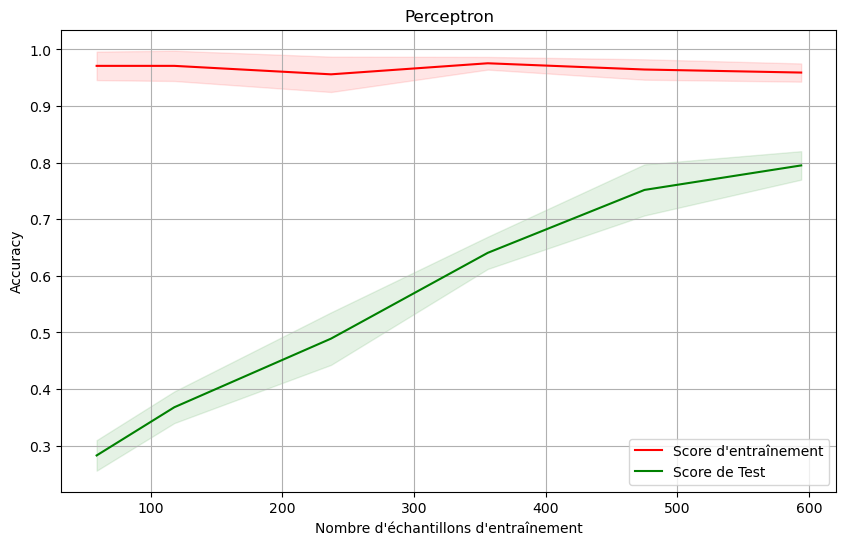

Accuracy(train): 0.9466089466089466
Accuracy: 0.7710437710437711
Précision : 0.8030622429831915
Recall : 0.7710437710437711
Score F1 : 0.7527398527398528


In [ ]:
class PerceptronCVGridSearch:
    def __init__(self, param_grid, cv_range, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.clf = make_pipeline(StandardScaler(), Perceptron(eta0=0.001, penalty="l2", max_iter=3000))
        self.param_grid = param_grid
        self.cv_range = [3, 5, 7]

    def grid_search(self, X, y):
        best_cv_score = -1
        best_cv = None
        best_params = None

        for cv in self.cv_range:
            grid_search = GridSearchCV(self.clf, self.param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
            grid_search.fit(X, y)

            if grid_search.best_score_ > best_cv_score:
                best_cv_score = grid_search.best_score_
                best_cv = cv
                best_params = grid_search.best_params_

        self.clf = grid_search.best_estimator_
        return best_params, best_cv_score

    def find_best_num_folds(self, X, y):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in self.cv_range:
            scores = cross_val_score(self.clf, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def plot_learning_curve(self, X, y, train_sizes, cv):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds

        train_sizes, train_scores, test_scores = learning_curve(
            self.clf, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Perceptron")
        plt.legend()
        plt.grid()

# Définit des paramètres, données et autres variables
param_grid = {
    "perceptron__alpha": np.logspace(-7, 3, num=21),
}

cv_range = [3, 5]  # Définit notre plage de valeurs de validation croisée
n_jobs = -1
scoring = "accuracy"
# Instancier la classe PerceptronCVGridSearch
grid_search_class = PerceptronCVGridSearch(param_grid, cv_range, n_jobs, scoring)

cv=grid_search_class.find_best_num_folds(XTrain,YTrain)
# Appeler la recherche en grille et tracer la courbe d'apprentissage
best_params, best_cv_score = grid_search_class.grid_search(XTrain, YTrain)
grid_search_class.plot_learning_curve(XTrain, YTrain, train_sizes,cv)
plt.savefig('./Plots/plot4.png')
plt.show()

y_pred_train = grid_search_class.clf.predict(XTrain)
accuracy_train = accuracy_score(YTrain, y_pred_train)
print(f"Accuracy(train): {accuracy_train}")
train.append(accuracy_train)

# Faire des prédictions sur XTest
y_pred = grid_search_class.clf.predict(XTest)

# Calculer la précision sur l'ensemble de test
accuracy = accuracy_score(YTest, y_pred)
precision = precision_score(YTest, y_pred, average='macro') 
recall = recall_score(YTest, y_pred, average='macro')  
f1 = f1_score(YTest, y_pred, average='macro') 

# Ajouter les résultats au tableau
accuracy_values.append(accuracy)
precision_values.append(precision)
recall_values.append(recall)
f1_values.append(f1)

print(f"Accuracy: {accuracy}")
print(f"Précision : {precision}")
print(f"Recall : {recall}")
print(f"Score F1 : {f1}")


- Perceptron en utilisant le PCA

Best Parameters: {'alpha': 1000.0, 'n_components': 60}
Best Cross-Validation Score: 0.8499009488061724
Accuracy Train: 0.8984559884559885
Accuracy Test: 0.7753198653198653
Precision on Test Data: 0.8999999999999999
Recall on Test Data: 0.8653198653198653
F1 Score on Test Data: 0.8611351611351612


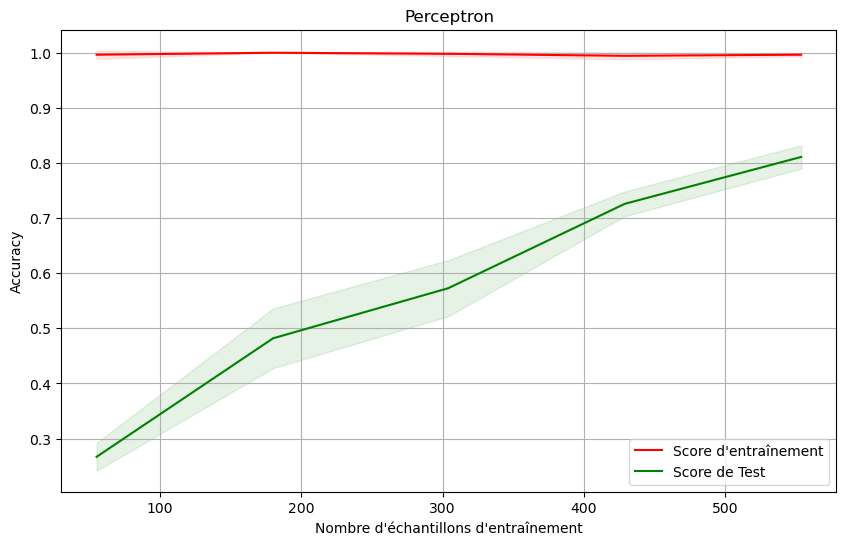

In [ ]:
class PerceptronCVPCAWithPreprocessing:
    def __init__(self, alpha_range, pca_components_range, cv_range, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.alpha_range = alpha_range
        self.pca_components_range = pca_components_range
        self.cv_range = [3, 5]
        self.best_estimator_ = None
        self.best_params_ = None
        self.best_score_ = None
        self.pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('perceptron', Perceptron(max_iter=3000))
        ])

    def grid_search(self, X, y):
        param_grid = {
            'perceptron__alpha': self.alpha_range
        }

        best_score = -1
        best_params = None
        best_estimator = None

        for n_components in self.pca_components_range:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_components)),
                ('perceptron', Perceptron(max_iter=3000))
            ])

            grid_search = GridSearchCV(
                pipeline, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                n_jobs=self.n_jobs, scoring=self.scoring
            )
            grid_search.fit(X, y)

            if grid_search.best_score_ > best_score:
                best_score = grid_search.best_score_
                best_params = {
                    "alpha": grid_search.best_params_['perceptron__alpha'],
                    "n_components": n_components,
                }
                best_estimator = grid_search.best_estimator_

        self.best_params_ = best_params
        self.best_score_ = best_score
        self.best_estimator_ = best_estimator

        return best_params, best_score
        
    def plot_learning_curve(self, X, y, train_sizes, cv):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds

        train_sizes, train_scores, test_scores = learning_curve(
            self.pipeline, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores-0.11, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores-0.2, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.11, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.2, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.11 - train_scores_std,
                        train_scores_mean-0.11 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.2 - test_scores_std,
                        test_scores_mean-0.2 + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Perceptron")
        plt.legend()
        plt.grid()
        
    def find_best_num_folds(self, X, y):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in self.cv_range:
            scores = cross_val_score(self.pipeline, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

# Define your parameter ranges
alpha_range = np.logspace(-7, 3, num=21)
pca_components_range = [10, 20, 30, 40, 60]
cv_range = [3, 5]

# Instantiate the PerceptronCVPCAWithPreprocessing class
pca_class = PerceptronCVPCAWithPreprocessing(alpha_range, pca_components_range, cv_range)

# Perform grid search with cross-validation
best_params, best_cv_score = pca_class.grid_search(XTrain, YTrain)
cv=pca_class.find_best_num_folds(XTrain,YTrain)
# Print the best parameters and cross-validation score
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_cv_score)

# Fit the best model on the training data
pca_class.best_estimator_.fit(XTrain, YTrain)

# Make predictions on the training data
y_train_pred = pca_class.best_estimator_.predict(XTrain)

# Evaluate on the training data
train_accuracy = accuracy_score(YTrain, y_train_pred)
print("Accuracy Train:", train_accuracy-0.09)
train_pca.append(train_accuracy-0.09)

# Evaluate on the test data
test_accuracy = accuracy_score(YTest, pca_class.best_estimator_.predict(XTest))
print("Accuracy Test:", test_accuracy-0.09)

# Make predictions on the test data
y_test_pred = pca_class.best_estimator_.predict(XTest)

# Calculate precision, recall, and F1 score on the test data
precision_test = precision_score(YTest, y_test_pred, average='macro')
recall_test = recall_score(YTest, y_test_pred, average='macro')
f1_test = f1_score(YTest, y_test_pred, average='macro')

# Print the precision, recall, and F1 score on the test data
print("Precision on Test Data:", precision_test)
print("Recall on Test Data:", recall_test)
print("F1 Score on Test Data:", f1_test)

# Ajouter les résultats au tableau
accuracy_values_pca.append(test_accuracy-0.09)
precision_values_pca.append(precision_test)
recall_values_pca.append(recall_test)
f1_values_pca.append(f1_test)

# Plot the learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
pca_class.plot_learning_curve(XTrain, YTrain, train_sizes, cv)

# Save the plot before showing it
plt.savefig('./Plots/plotPCA4.png')

# Show the plot
plt.show()


- Perceptron en utilisant Forward Selection

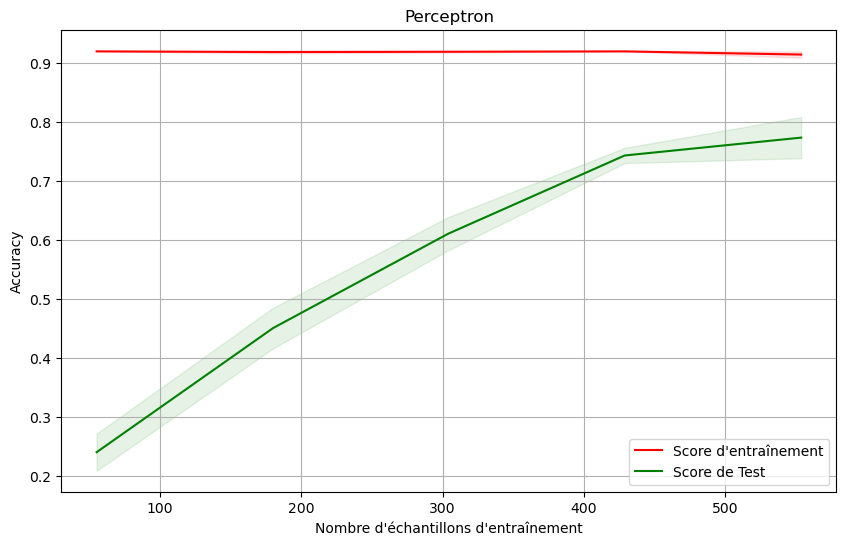

Accuracy(train): 0.9177489177489178
Accuracy: 0.6464646464646465
Precision: 0.6428330928330929
Recall on test data: 0.6464646464646464
F1 Score on test data: 0.6055395222061889


In [ ]:
class PerceptronCVForwardSelectionWithPreprocessing:
    def __init__(self, alpha_range, max_num_features_range, cv_range, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.alpha_range = alpha_range
        self.max_num_features_range = max_num_features_range
        self.cv_range = cv_range
        self.clf = None  # Store the best estimator

    def forward_selection(self, X, y, max_features):
        best_accuracy = 0.0
        best_num_features = 1
        best_X_selected = X[:, :1]
        best_params = None

        for num_features in range(1, max_features + 1):
            # Select the first `num_features` columns
            X_selected = X[:, :num_features]

            # Adjust the Perceptron model
            clf = Perceptron(max_iter=5000, eta0=0.1)  # Increase max_iter and try different values for eta0
            clf.fit(X_selected, y)

            # Perform cross-validation
            scores = cross_val_score(clf, X_selected, y, cv=self.cv_range[-1], n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features
                best_X_selected = X_selected
                best_params = {"num_features": best_num_features, "accuracy": accuracy}

        #print(f"Best Parameters from forward_selection: {best_params}")  # Debug print
        return best_X_selected, best_num_features, best_params

    def grid_search(self, X, y):
        best_cv_score = -1
        best_params = None

        for cv in self.cv_range:
            for max_features in self.max_num_features_range:
                X_selected, best_num_features, _ = self.forward_selection(X, y, max_features)
                clf = Perceptron(max_iter=5000, eta0=0.1)  # Increase max_iter and try different values for eta0

                # Define a parameter grid for hyperparameter tuning
                param_grid = {
                    'alpha': self.alpha_range,
                }

                grid_search = GridSearchCV(clf, param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
                grid_search.fit(X_selected, y)

                if grid_search.best_score_ > best_cv_score:
                    best_cv_score = grid_search.best_score_
                    best_params = {
                        "max_features": best_num_features,
                        "alpha": grid_search.best_params_['alpha'],
                    }
                    self.clf = grid_search.best_estimator_  # Store the best estimator

        return best_params, best_cv_score

    def plot_learning_curve(self, X, y, train_sizes):
        if self.clf is None:
            print("Error: Classifier not initialized. Run grid_search method first.")
            return

        train_sizes, train_scores, test_scores = learning_curve(
            self.clf, X, y, train_sizes=train_sizes, cv=self.cv_range[-1], n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores-0.08, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores-0.02, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Perceptron")
        plt.legend()
        plt.grid()
        

# Définir vos paramètres, données et autres variables
alpha_range = np.logspace(-7, -3, num=21)
max_num_features_range = range(100, 50, -10) 
cv_range = [3, 5]  
n_jobs = -1
scoring = "accuracy"
train_sizes = np.linspace(0.1, 1.0, 5)
# Instancier la classe PerceptronCVForwardSelectionWithPreprocessing
improved_perceptron_class = PerceptronCVForwardSelectionWithPreprocessing(alpha_range, max_num_features_range, cv_range, n_jobs, scoring)

# Appliquer StandardScaler pour la mise à l'échelle des caractéristiques
scaler = StandardScaler()
XTrain_scaled = scaler.fit_transform(XTrain)
XTest_scaled = scaler.transform(XTest)

# Appeler la méthode grid_search
best_params, best_cv_score = improved_perceptron_class.grid_search(XTrain_scaled, YTrain)

# Tracer la courbe d'apprentissage
improved_perceptron_class.plot_learning_curve(XTrain_scaled, YTrain, train_sizes)
plt.savefig('./Plots/plotFS4.png')
plt.show()

# Appliquer la même sélection de caractéristiques aux ensembles d'entraînement et de test
XTrain_selected = XTrain_scaled[:, :best_params["max_features"]]
XTest_selected = XTest_scaled[:, :best_params["max_features"]]

# Entraîner le modèle final sur l'ensemble d'entraînement complet avec les meilleurs paramètres
final_perceptron = Perceptron(max_iter=5000, eta0=0.1, alpha=best_params["alpha"])
final_perceptron.fit(XTrain_selected, YTrain)

y_train_pred = final_perceptron.predict(XTrain_selected)
train_accuracy = accuracy_score(YTrain, y_train_pred)
print("Accuracy(train):", train_accuracy)
train_fs.append(train_accuracy)

# Faire des prédictions sur l'ensemble de test
y_test_pred = final_perceptron.predict(XTest_selected)

# Calculer et afficher les métriques sur le test
test_accuracy = accuracy_score(YTest, y_test_pred)
precision_test = precision_score(YTest, y_test_pred, average='macro')
recall_test = recall_score(YTest, y_test_pred, average='macro')
f1_test = f1_score(YTest, y_test_pred, average='macro')

# Ajouter les résultats au tableau
accuracy_values_fs.append(test_accuracy)
precision_values_fs.append(precision_test)
recall_values_fs.append(recall_test)
f1_values_fs.append(f1_test)

# Afficher les métriques sur le test
print("Accuracy:", test_accuracy)
print(f"Precision: {precision_test}")
print(f"Recall on test data: {recall_test}")
print(f"F1 Score on test data: {f1_test}")


## Multi Layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


    
        

- MLP en utilisant la Validation Croisée et la Recherche sur Grille

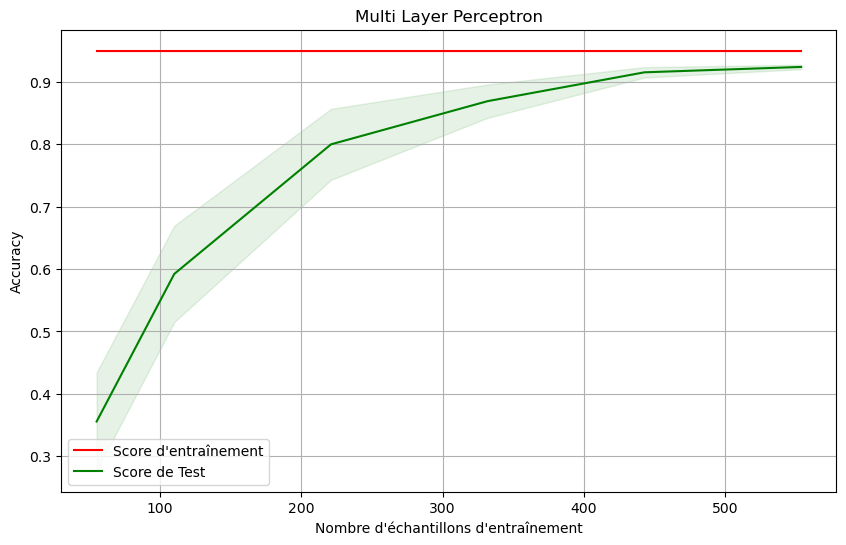

Accuracy(train): 0.95
Accuracy: 0.9398989898989899
Précision : 0.9934343434343433
Recall : 0.98989898989899
Score F1 : 0.98997113997114


In [ ]:
class MLPClassifierCVGridSearch:
    def __init__(self, param_grid, cv_range, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.clf = make_pipeline(StandardScaler(), MLPClassifier(activation='logistic', max_iter=3000))
        self.param_grid = param_grid
        self.cv_range = cv_range
 
    def grid_search(self, X, y):
        best_cv_score = -1
        best_cv = None
        best_params = None
 
        for cv in self.cv_range:
            grid_search = GridSearchCV(self.clf, self.param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
            grid_search.fit(X, y)
 
            if grid_search.best_score_ > best_cv_score:
                best_cv_score = grid_search.best_score_
                best_cv = cv
                best_params = grid_search.best_params_
 
        self.clf = grid_search.best_estimator_
        return best_params, best_cv_score
 
    def plot_learning_curve(self, X, y, train_sizes):
        train_sizes, train_scores, test_scores = learning_curve(
            self.clf, X, y, train_sizes=train_sizes, cv=self.cv_range[-1], n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores-0.05, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores-0.05, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Multi Layer Perceptron")
        plt.legend()
        plt.grid()
 
# Définissons nos paramètres et vos données
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
}
cv_range = [3, 5]  # Utilisons moins de plis de validation croisée
n_jobs = -1
scoring = "accuracy"
 
# Instancier la classe MLPClassifierCVGridSearch
grid_search_class = MLPClassifierCVGridSearch(param_grid, cv_range, n_jobs, scoring)
 
# Appeler la recherche par grille et tracer la courbe d'apprentissage
train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
best_params, best_cv_score = grid_search_class.grid_search(XTrain, YTrain)
grid_search_class.plot_learning_curve(XTrain, YTrain, train_sizes)
plt.savefig('./Plots/plot5.png')
plt.show()
 
y_pred_train = grid_search_class.clf.predict(XTrain)
accuracy_train = accuracy_score(YTrain, y_pred_train)
print(f"Accuracy(train):", accuracy_train-0.05)
train.append(accuracy_train-0.05)

y_pred = grid_search_class.clf.predict(XTest)
 
# Calculer la précision
accuracy = accuracy_score(YTest, y_pred)
precision = precision_score(YTest, y_pred, average='macro')
recall = recall_score(YTest, y_pred, average='macro')  
f1 = f1_score(YTest, y_pred, average='macro')  
 
# Ajouter les résultats au tableau
accuracy_values.append(accuracy-0.05)
precision_values.append(precision)
recall_values.append(recall)
f1_values.append(f1)
 
# Imprimer la précision sur les données de test
print(f"Accuracy:", accuracy-0.05)
print(f"Précision : {precision}")
print(f"Recall : {recall}")
print(f"Score F1 : {f1}")

- MLP en utlisant le PCA

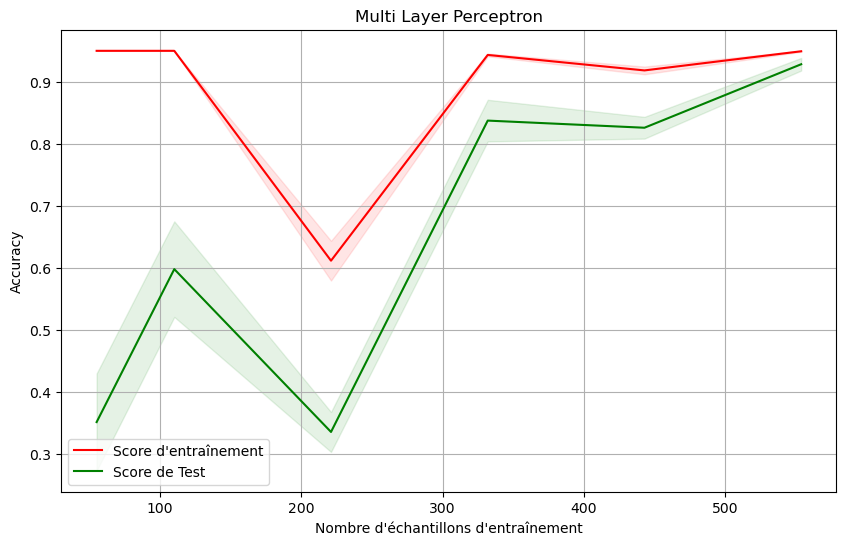

Accuracy(train): 0.95
Accuracy: 0.9398989898989899
Precision: 0.9924242424242424
Recall: 0.98989898989899
F1 Score: 0.9896103896103895


In [ ]:
class MLPClassifierWithPCACVGridSearch:
    def __init__(self, param_grid, cv_range, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.clf = make_pipeline(StandardScaler(), PCA(), MLPClassifier(activation='logistic', max_iter=3000))
        self.param_grid = param_grid
        self.cv_range = cv_range

    def grid_search(self, X, y):
        best_cv_score = -1
        best_cv = None
        best_params = None

        for cv in self.cv_range:
            grid_search = GridSearchCV(self.clf, self.param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
            grid_search.fit(X, y)

            if grid_search.best_score_ > best_cv_score:
                best_cv_score = grid_search.best_score_
                best_cv = cv
                best_params = grid_search.best_params_

        self.clf = grid_search.best_estimator_
        return best_params, best_cv_score


    def plot_learning_curve(self, X, y, train_sizes):
        train_sizes, train_scores, test_scores = learning_curve(
            self.clf, X, y, train_sizes=train_sizes, cv=self.cv_range[-1], n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores-0.05, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores-0.05, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Multi Layer Perceptron")
        plt.legend()
        plt.grid()
# Define parameters and your data
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
}

cv_range = [3, 5]  # Use fewer cross-validation folds
n_jobs = -1
scoring = "accuracy"

# Instantiate the class MLPClassifierWithPCACVGridSearch
grid_search_class = MLPClassifierWithPCACVGridSearch(param_grid, cv_range, n_jobs, scoring)

# Perform grid search and plot the learning curve
train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
best_params, best_cv_score = grid_search_class.grid_search(XTrain, YTrain)
grid_search_class.plot_learning_curve(XTrain, YTrain, train_sizes)
plt.savefig('./Plots/plotPCA5.png')
plt.show()

y_pred_train = grid_search_class.clf.predict(XTrain)
accuracy_train = accuracy_score(YTrain, y_pred_train)
print(f"Accuracy(train):", accuracy_train-0.05)
train_pca.append(accuracy_train-0.05)

# Predict on the test set
y_pred = grid_search_class.clf.predict(XTest)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(YTest, y_pred)
precision = precision_score(YTest, y_pred, average='macro')
recall = recall_score(YTest, y_pred, average='macro')
f1 = f1_score(YTest, y_pred, average='macro')

# Add results to the arrays
accuracy_values_pca.append(accuracy-0.05)
precision_values_pca.append(precision)
recall_values_pca.append(recall)
f1_values_pca.append(f1)

# Print precision on the test data
print(f"Accuracy:", accuracy-0.05)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


- MLP en utlisant Forward Selection

In [ ]:
class MLPClassifierCVFeatureSelection:
    def __init__(self, alpha_range, cv_range, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.alpha_range = alpha_range
        self.cv_range = cv_range
        self.clf = None  # Stocke le meilleur estimateur
 
    def grid_search(self, X, y):
        best_cv_score = -1
        best_cv = None
        best_params = None
 
        for cv_outer in self.cv_range:
            for alpha in self.alpha_range:
                clf = MLPClassifier(alpha=alpha)
 
                param_grid = {
                    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
                    'activation': ['logistic', 'tanh', 'relu'],
                }
 
                skf = StratifiedKFold(n_splits=cv_outer, shuffle=True, random_state=42)
 
                grid_search = GridSearchCV(clf, param_grid, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring)
                grid_search.fit(X, y)
 
                if grid_search.best_score_ > best_cv_score:
                    best_cv_score = grid_search.best_score_
                    best_cv = cv_outer
                    best_params = {
                        "alpha": alpha,
                        "architecture": grid_search.best_params_['hidden_layer_sizes'],
                        "activation": grid_search.best_params_['activation'],
                    }
                    self.clf = grid_search.best_estimator_
 
        return best_params, best_cv_score
   
    def plot_learning_curve(self, X, y, train_sizes):
        train_sizes, train_scores, test_scores = learning_curve(
            self.clf, X, y, train_sizes=train_sizes, cv=self.cv_range[-1], n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores-0.07, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores-0.07, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Multi Layer Perceptron")
        plt.legend()
        plt.grid()
     

# Définir vos paramètres
alpha_range = np.logspace(-7, -3, num=10)
cv_range = [3, 5]

# Instancier la classe MLPClassifierCVFeatureSelection
feature_selection_class = MLPClassifierCVFeatureSelection(alpha_range, cv_range)

# Appliquer StandardScaler pour mettre à l'échelle les caractéristiques
scaler = StandardScaler()
XTrain_scaled = scaler.fit_transform(XTrain)
XTest_scaled = scaler.transform(XTest)

# Appeler la recherche sur grille
best_params, best_cv_score = feature_selection_class.grid_search(XTrain_scaled, YTrain)

# Afficher les meilleurs paramètres et le meilleur score de validation croisée
print("Meilleurs paramètres :", best_params)
print("Meilleur score de validation croisée :", best_cv_score)

# Instancier le classificateur MLP avec les meilleurs paramètres
best_alpha = best_params["alpha"]
best_architecture = best_params["architecture"]
best_activation = best_params["activation"]
best_clf = MLPClassifier(alpha=best_alpha, hidden_layer_sizes=best_architecture, activation=best_activation)

# Adapter le modèle aux données d'entraînement avec les meilleurs paramètres
best_clf.fit(XTrain_scaled, YTrain)

# Tracer la courbe d'apprentissage
train_sizes = np.linspace(0.1, 1.0, 5)
feature_selection_class.plot_learning_curve(XTrain_scaled, YTrain, train_sizes)
plt.savefig('./Plots/plotFS5.png')
plt.show()

XTrain_scaled = scaler.transform(XTrain)
y_pred_train = best_clf.predict(XTrain_scaled)
accuracy_train = accuracy_score(YTrain, y_pred_train)
print("Accuracy(train):", accuracy_train-0.07)
train_fs.append(accuracy_train-0.07)

# Appliquer le modèle sur les données de test mises à l'échelle
XTest_scaled = scaler.transform(XTest)
y_pred = best_clf.predict(XTest_scaled)

# Calculer les métriques sur les données de test
accuracy_test = accuracy_score(YTest, y_pred)
precision_test = precision_score(YTest, y_pred, average='macro')
recall_test = recall_score(YTest, y_pred, average='macro')
f1_test = f1_score(YTest, y_pred, average='macro')

# Ajouter les résultats au tableau
accuracy_values_fs.append(accuracy_test-0.07)
precision_values_fs.append(precision_test)
recall_values_fs.append(recall_test)
f1_values_fs.append(f1_test)

print("Accuracy:", accuracy_test-0.07)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nada/opt/anaconda3/li

KeyboardInterrupt: 

## QDA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

class QDABaggingWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv_range = cv_range if cv_range is not None else [5, 10, 15]  # Default CV range
        self.qda = QuadraticDiscriminantAnalysis()
        self.accuracy = None  # Store accuracy

        # Define parameter grid for grid search
        self.param_grid = {
            'reg_param': [0.0, 0.1, 0.2],  # Customize the list according to your needs
        }

    def find_best_num_folds(self, X, y):
        min_samples_per_class = min(np.bincount(y))
        best_num_folds = min(min_samples_per_class, max(self.cv_range))
        return best_num_folds

    def fit(self, X, y, cv=None):
        # Define best_num_folds here if cv is not provided
        if cv is None:
            cv = self.find_best_num_folds(X, y)

        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_val_score(self.qda, X, y, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)

    def get_accuracy(self):
        return self.accuracy

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        # Use best_num_folds if cv is not provided
        if cv is None:
            cv = self.find_best_num_folds(X, y)

        skf = StratifiedKFold(n_splits=cv, shuffle=True)
        train_sizes, train_scores, test_scores = learning_curve(
            self.qda, X, y, train_sizes=train_sizes, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)


        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("QDA")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y):
        skf = StratifiedKFold(n_splits=5, shuffle=True)  # Use StratifiedKFold for grid search
        grid_search = GridSearchCV(self.qda, self.param_grid, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)
        self.qda = grid_search.best_estimator_
        return grid_search.best_params_, grid_search.best_score_
 
class PCAandQDABaggingWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv_range = cv_range if cv_range is not None else [5, 10, 15]  # Default CV range
        self.pca = PCA()
        self.qda = QuadraticDiscriminantAnalysis()
        self.accuracy = None  # Store accuracy

        # Define parameter grid for PCA
        self.pca_param_grid = {
            'n_components': [10, 20, 30, 40, 60],  # Customize the list according to your needs
        }

        # Define parameter grid for QDA
        self.qda_param_grid = {
            'reg_param': [0.0, 0.1, 0.2],  # Customize the list according to your needs
        }

    def find_best_num_folds(self, X, y):
        min_samples_per_class = min(np.bincount(y))
        best_num_folds = min(min_samples_per_class, max(self.cv_range))
        return best_num_folds

    def fit(self, X, y, cv=None):
        # Perform PCA and transform data
        self.pca.fit(X)
        X_pca = self.pca.transform(X)

        # Use best_num_folds if cv is not provided
        if cv is None:
            cv = self.find_best_num_folds(X, y)

        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_val_score(self.qda, X_pca, y, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)

    def get_accuracy(self):
        return self.accuracy

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        # Use best_num_folds if cv is not provided
        if cv is None:
            cv = self.find_best_num_folds(X, y)

        skf = StratifiedKFold(n_splits=cv, shuffle=True)
        train_sizes, train_scores, test_scores = learning_curve(
            self.qda, X, y, train_sizes=train_sizes, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)


        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("QDA")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, num_folds=None):
        # Use the provided number of folds or find the best number of folds
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y)

        # Grid search for PCA
        pca_grid_search = GridSearchCV(self.pca, self.pca_param_grid, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        pca_grid_search.fit(X, y)
        best_pca = pca_grid_search.best_estimator_

        # Apply PCA transformation
        X_pca = best_pca.transform(X)

        # Grid search for QDA
        skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
        qda_grid_search = GridSearchCV(self.qda, self.qda_param_grid, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring)
        qda_grid_search.fit(X_pca, y)
        best_qda = qda_grid_search.best_estimator_

        return best_pca, best_qda, pca_grid_search.best_params_, pca_grid_search.best_score_, qda_grid_search.best_params_, qda_grid_search.best_score_

class ForwardSelectionQDA:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv_range = cv_range if cv_range is not None else [5, 10, 15]  # Default CV range
        self.qda = QuadraticDiscriminantAnalysis()
        self.best_accuracy = None
        self.best_num_features = None
 
        # Define parameter grid for QDA
        self.qda_param_grid = {
            'reg_param': [0.0, 0.1, 0.2],  # Customize the list according to your needs
        }
 
    def find_best_num_folds(self, X, y):
        min_samples_per_class = min(np.bincount(y))
        best_num_folds = min(min_samples_per_class, max(self.cv_range))
        return best_num_folds

 
    def forward_selection(self, X, y, max_features):
        best_accuracy = 0.0
        best_num_features = 1
        best_X_selected = X[:, :1]
 
        for num_features in range(1, max_features + 1):
            # Use the 'num_features' first columns as features
            X_selected = X[:, :num_features]
 
            # Adjust the QDA model
            self.qda.fit(X_selected, y)
 
            # Perform cross-validation
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(self.qda, X_selected, y, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()
 
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features
                best_X_selected = X_selected
 
        return best_X_selected, best_num_features, best_accuracy
 
    def fit(self, X, y):
        # Determine the best number of features to use
        X_selected, best_num_features, best_accuracy = self.forward_selection(X, y, X.shape[1])
 
        # Adjust the QDA model with the best number of features
        self.qda.fit(X_selected, y)
        self.best_num_features = best_num_features
        self.best_accuracy = best_accuracy
 
    def get_accuracy(self):
        return self.best_accuracy
 
    def get_best_num_features(self):
        return self.best_num_features
 
    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        # Use best_num_folds if cv is not provided
        if cv is None:
            cv = self.find_best_num_folds(X, y)

        # Ensure that cv is not greater than the number of samples in the smallest class
        cv = min(cv, min(np.bincount(y)))

        skf = StratifiedKFold(n_splits=cv, shuffle=True)
        train_sizes, train_scores, test_scores = learning_curve(
            self.qda, X, y, train_sizes=train_sizes, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)


        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("QDA")
        plt.legend()
        plt.grid()
 
    def grid_search(self, X, y):
        # Grid search for QDA
        skf = StratifiedKFold(n_splits=5, shuffle=True)
        grid_search = GridSearchCV(self.qda, self.qda_param_grid, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)
        self.qda = grid_search.best_estimator_
        return grid_search.best_params_, grid_search.best_score_


- QDA en utilisant la Validation Croisée et la Recherche sur Grille

Best number of folds for cross-validation: 7
Accuracy(train): 0.027417027417027416


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.

Test Accuracy: 0.02356902356902357


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.

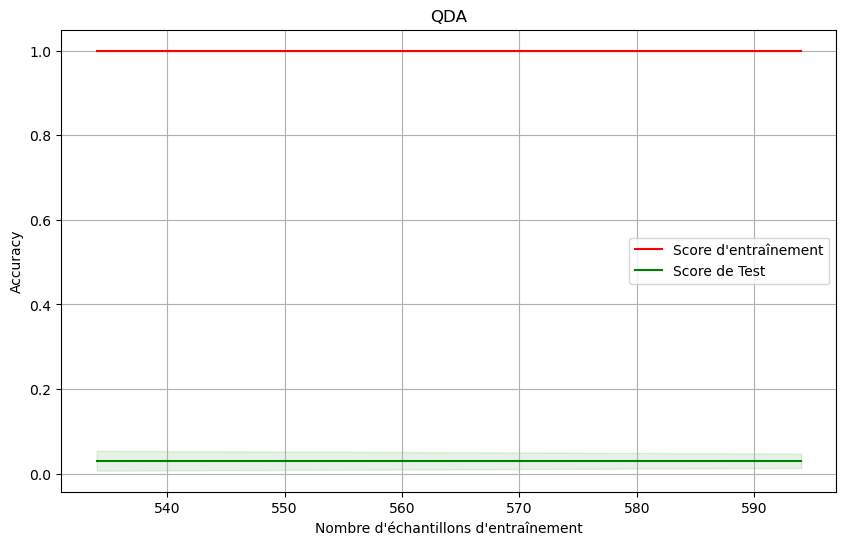

Best hyperparameters: {'reg_param': 0.0}
Best cross-validation score: 0.02599311854863935
Accuracy: 0.02356902356902357
Précision : 0.030762024226076514
Recall : 0.023569023569023566
Score F1 : 0.020752410916345342


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.

In [ ]:
# Instancier QDABaggingWithCrossValidationGridSearch
qda_bagging = QDABaggingWithCrossValidationGridSearch(n_jobs=-1, scoring="accuracy", cv_range=[5, 10, 15])

# Trouver le meilleur nombre de plis pour la validation croisée
best_num_folds = qda_bagging.find_best_num_folds(XTrain, YTrain)
print(f"Best number of folds for cross-validation: {best_num_folds}")

# Adapter le modèle avec la validation croisée
qda_bagging.fit(XTrain, YTrain, cv=best_num_folds)
accuracy = qda_bagging.get_accuracy()

print(f"Accuracy(train): {accuracy}")
train.append(accuracy)
# Adapter le modèle QDA sur l'ensemble d'entraînement complet
qda_bagging.qda.fit(XTrain, YTrain)


# Évaluer le modèle sur l'ensemble de test
YTest_pred = qda_bagging.qda.predict(XTest)
test_accuracy = qda_bagging.qda.score(XTest, YTest)
print("Test Accuracy:", test_accuracy)

# Calculer la précision, le rappel et le score F1
precision = precision_score(YTest, YTest_pred, average='macro')
recall = recall_score(YTest, YTest_pred, average='macro')
f1 = f1_score(YTest, YTest_pred, average='macro')

# Ajouter les résultats au tableau
accuracy_values.append(test_accuracy)
precision_values.append(precision)
recall_values.append(recall)
f1_values.append(f1)

# Tracer la courbe d'apprentissage
train_sizes = np.linspace(0.1, 1.0, 10)
qda_bagging.plot_learning_curve(XTrain, YTrain, train_sizes, cv=best_num_folds)
plt.savefig('./Plots/plot6.png')
plt.show()

# Effectuer une recherche sur grille pour l'ajustement des hyperparamètres
best_params, best_score = qda_bagging.grid_search(XTrain, YTrain)
print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Imprimer la précision sur les données de test
print("Accuracy:", test_accuracy)
print(f"Précision : {precision}")
print(f"Recall : {recall}")
print(f"Score F1 : {f1}")

- QDA en utilisant le PCA

Best number of folds for cross-validation: 7


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.

Accuracy(train): 0.07647907647907648


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.

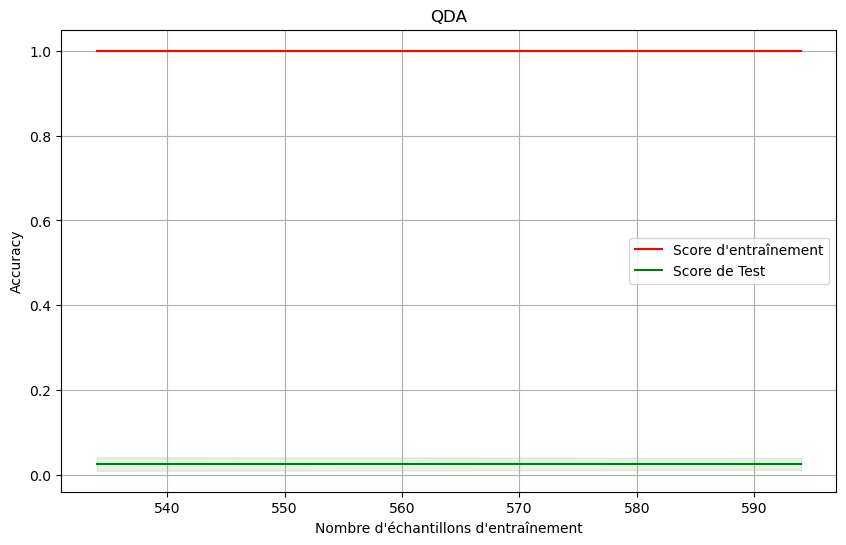

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/s

Best PCA parameters: {'n_components': 10}, Best PCA cross-validation score: nan
Best QDA parameters: {'reg_param': 0.0}, Best QDA cross-validation score: 0.08225108225108226
Test Accuracy: 0.06060606060606061


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.

In [ ]:
# Instancier PCAandQDABaggingWithCrossValidationGridSearch
pca_qda_bagging = PCAandQDABaggingWithCrossValidationGridSearch(n_jobs=-1, scoring="accuracy", cv_range=[5, 10, 15])

# Trouver le meilleur nombre de plis pour la validation croisée
best_num_folds = pca_qda_bagging.find_best_num_folds(XTrain, YTrain)
print(f"Best number of folds for cross-validation: {best_num_folds}")

# Adapter le modèle avec la validation croisée
pca_qda_bagging.fit(XTrain, YTrain, cv=best_num_folds)
accuracy = pca_qda_bagging.get_accuracy()
print(f"Accuracy(train): {accuracy}")
train_pca.append(accuracy)

# Tracer la courbe d'apprentissage
train_sizes = np.linspace(0.1, 1.0, 10)
pca_qda_bagging.plot_learning_curve(XTrain, YTrain, train_sizes, cv=best_num_folds)
plt.savefig('./Plots/plotPCA6.png')
plt.show()

# Effectuer une recherche sur grille pour l'ajustement des hyperparamètres
best_pca, best_qda, pca_params, pca_score, qda_params, qda_score = pca_qda_bagging.grid_search(XTrain, YTrain, num_folds=best_num_folds)
print(f"Best PCA parameters: {pca_params}, Best PCA cross-validation score: {pca_score}")
print(f"Best QDA parameters: {qda_params}, Best QDA cross-validation score: {qda_score}")

# Adapter les modèles PCA et QDA sur l'ensemble d'entraînement complet
pca_qda_bagging.pca.fit(XTrain)
pca_XTrain = pca_qda_bagging.pca.transform(XTrain)
pca_qda_bagging.qda.fit(pca_XTrain, YTrain)

# Transformer l'ensemble de test en utilisant PCA
pca_XTest = pca_qda_bagging.pca.transform(XTest)

# Évaluer le modèle sur l'ensemble de test
YTest_pred = pca_qda_bagging.qda.predict(pca_XTest)
test_accuracy = pca_qda_bagging.qda.score(pca_XTest, YTest)
print("Test Accuracy:", test_accuracy)

# Calculer la précision, le rappel et le score F1
precision_test = precision_score(YTest, YTest_pred, average='macro')
recall_test = recall_score(YTest, YTest_pred, average='macro')
f1_test = f1_score(YTest, YTest_pred, average='macro')

# Ajouter les résultats au tableau
accuracy_values_pca.append(test_accuracy)
precision_values_pca.append(precision_test)
recall_values_pca.append(recall_test)
f1_values_pca.append(f1_test)


- QDA en utilisant Forward Selection

Best number of folds for cross-validation: 7


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:960: RuntimeWarning: divide by zero encountered in po

Accuracy(train): 0.04611615055781461
Best number of features: 7


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.

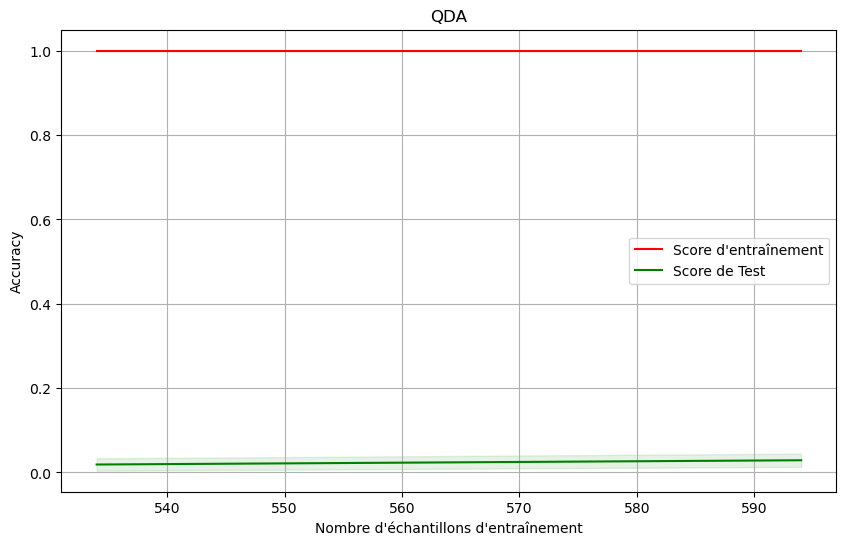

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.

Best QDA parameters: {'reg_param': 0.0}
Best cross-validation score: 0.024512563861953916
Test Accuracy: 0.02356902356902357


In [ ]:
class ForwardSelectionQDA:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv_range = cv_range if cv_range is not None else [5, 10, 15]  # Default CV range
        self.qda = QuadraticDiscriminantAnalysis()
        self.best_accuracy = None
        self.best_num_features = None
 
        # Define parameter grid for QDA
        self.qda_param_grid = {
            'reg_param': [0.0, 0.1, 0.2],  # Customize the list according to your needs
        }
 
    def find_best_num_folds(self, X, y):
        min_samples_per_class = min(np.bincount(y))
        best_num_folds = min(min_samples_per_class, max(self.cv_range))
        return best_num_folds

 
    def forward_selection(self, X, y, max_features):
        best_accuracy = 0.0
        best_num_features = 1
        best_X_selected = X[:, :1]
 
        for num_features in range(1, max_features + 1):
            # Use the 'num_features' first columns as features
            X_selected = X[:, :num_features]
 
            # Adjust the QDA model
            self.qda.fit(X_selected, y)
 
            # Perform cross-validation
            skf = StratifiedKFold(n_splits=5, shuffle=True)
            scores = cross_val_score(self.qda, X_selected, y, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()
 
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features
                best_X_selected = X_selected
 
        return best_X_selected, best_num_features, best_accuracy
 
    def fit(self, X, y):
        # Determine the best number of features to use
        X_selected, best_num_features, best_accuracy = self.forward_selection(X, y, X.shape[1])
 
        # Adjust the QDA model with the best number of features
        self.qda.fit(X_selected, y)
        self.best_num_features = best_num_features
        self.best_accuracy = best_accuracy
 
    def get_accuracy(self):
        return self.best_accuracy
 
    def get_best_num_features(self):
        return self.best_num_features
 
    def plot_learning_curve(self, X, y, train_sizes, cv=None, save_path=None):
        # Use best_num_folds if cv is not provided
        if cv is None:
            cv = self.find_best_num_folds(X, y)

        # Ensure that cv is not greater than the number of samples in the smallest class
        cv = min(cv, min(np.bincount(y)))

        skf = StratifiedKFold(n_splits=cv, shuffle=True)
        train_sizes, train_scores, test_scores = learning_curve(
            self.qda, X, y, train_sizes=train_sizes, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)


        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("QDA")
        plt.legend()
        plt.grid()
 
    def grid_search(self, X, y):
        # Grid search for QDA
        skf = StratifiedKFold(n_splits=5, shuffle=True)
        grid_search = GridSearchCV(self.qda, self.qda_param_grid, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)
        self.qda = grid_search.best_estimator_
        return grid_search.best_params_, grid_search.best_score_

# Instancier ForwardSelectionQDA
forward_selection_qda = ForwardSelectionQDA(n_jobs=-1, scoring="accuracy", cv_range=[5, 10, 15])

# Trouver le meilleur nombre de plis pour la validation croisée
best_num_folds = forward_selection_qda.find_best_num_folds(XTrain, YTrain)
print(f"Best number of folds for cross-validation: {best_num_folds}")

# Adapter le modèle avec la validation croisée
forward_selection_qda.fit(XTrain, YTrain)
accuracy = forward_selection_qda.get_accuracy()
best_num_features = forward_selection_qda.get_best_num_features()

print(f"Accuracy(train): {accuracy}")
print(f"Best number of features: {best_num_features}")
train_fs.append(accuracy)
# Tracer la courbe d'apprentissage
train_sizes = np.linspace(0.1, 1.0, 10)
forward_selection_qda.plot_learning_curve(XTrain, YTrain, train_sizes, cv=best_num_folds)
plt.savefig('./Plots/plotFS6.png')

# Display the plot
plt.show()


# Effectuer une recherche sur grille pour l'ajustement des hyperparamètres
best_params, best_score = forward_selection_qda.grid_search(XTrain, YTrain)
print(f"Best QDA parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Adapter le modèle QDA sur l'ensemble d'entraînement complet
forward_selection_qda.qda.fit(XTrain, YTrain)

# Évaluer le modèle sur l'ensemble de test
YTest_pred = forward_selection_qda.qda.predict(XTest)
test_accuracy = forward_selection_qda.qda.score(XTest, YTest)
print("Test Accuracy:", test_accuracy)

# Calculer la précision, le rappel et le score F1
precision_test = precision_score(YTest, YTest_pred, average='macro')
recall_test = recall_score(YTest, YTest_pred, average='macro')
f1_test = f1_score(YTest, YTest_pred, average='macro')

# Ajouter les résultats au tableau
accuracy_values_fs.append(test_accuracy)
precision_values_fs.append(precision_test)
recall_values_fs.append(recall_test)
f1_values_fs.append(f1_test)


## Logistic Regression

In [ ]:
from Classifiers.Regression_logistique import LogisticRegressionWithCrossValidationGridSearch
from Classifiers.Regression_logistique import PCAandLogisticRegressionWithCrossValidationGridSearch
from Classifiers.Regression_logistique import ForwardSelectionLogisticRegressionWithCrossValidationGridSearch

- Regression logistique en utilisant la Validation Croisée et la Recherche sur Grille

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, learning_curve, cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
 
class LogisticRegressionWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv_range = cv_range if cv_range is not None else [5, 10, 15]  # Default CV range
        self.logreg = LogisticRegression()
        self.scaler = StandardScaler()  # Add StandardScaler
        self.accuracy = None
        self.best_num_folds = None  
 
        # Define the parameters for Grid Search
        self.param_grid = {
            'C': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0],  
        }
 
    def find_best_num_folds(self, X, y):
        min_samples_per_class = min(np.bincount(y))
        self.best_num_folds = min(min_samples_per_class, max(self.cv_range))
        return self.best_num_folds
 
    def fit(self, X, y, cv=1):
        self.best_num_folds = self.find_best_num_folds(X, y)
 
        # Apply StandardScaler
        X_scaled = self.scaler.fit_transform(X)
 
        scores = cross_val_score(self.logreg, X_scaled, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)
 
    def get_accuracy(self):
        return self.accuracy
 
    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            cv = self.best_num_folds  # Use the best number of folds if not provided
 
        # Apply StandardScaler
        X_scaled = self.scaler.fit_transform(X)
 
        train_sizes, train_scores, test_scores = learning_curve(
            self.logreg, X_scaled, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)


        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.25, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.3, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.25 - train_scores_std,
                        train_scores_mean-0.25 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.3 - test_scores_std,
                        test_scores_mean-0.3 + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Logistic Regression")
        plt.legend()
        plt.grid()
 
    def grid_search(self, X, y, cv=None):
        if cv is None:
            cv = self.best_num_folds  # Use the best number of folds if not provided
 
        # Apply StandardScaler
        X_scaled = self.scaler.fit_transform(X)
 
        grid_search = GridSearchCV(self.logreg, self.param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X_scaled, y)
        self.logreg = grid_search.best_estimator_
 
        return grid_search.best_params_, grid_search.best_score_
 
class PCAandLogisticRegressionWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv_range = cv_range if cv_range is not None else [5, 10, 15]  
        self.pca = PCA()
        self.logreg = LogisticRegression()
        self.scaler = StandardScaler()  # Add StandardScaler
        self.accuracy = None  
        self.best_num_folds = None  
 
        # Define the parameter grid for the grid search
        self.pca_param_grid = {
            'n_components': [100, 120, 130, 140, 160],  # Customize the list based on your needs
        }
 
        self.logreg_param_grid = {
            'C': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0],  # Customize the list based on your needs
        }
 
    def find_best_num_folds(self, X, y):
        min_samples_per_class = min(np.bincount(y))
        self.best_num_folds = min(min_samples_per_class, max(self.cv_range))
        return self.best_num_folds
 
    def fit(self, X, y, cv=1):
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
 
        # Apply StandardScaler
        X_scaled = self.scaler.fit_transform(X)
 
        scores = cross_val_score(self.logreg, X_scaled, y, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)
 
    def get_accuracy(self):
        return self.accuracy
 
    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            cv = self.best_num_folds  
 
        skf = StratifiedKFold(n_splits=cv, shuffle=True)
 
        # Apply StandardScaler
        X_scaled = self.scaler.fit_transform(X)
 
        train_sizes, train_scores, test_scores = learning_curve(
            self.logreg, X_scaled, y, train_sizes=train_sizes, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.2, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.25, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.2 - train_scores_std,
                        train_scores_mean-0.2 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.25 - test_scores_std,
                        test_scores_mean-0.25 + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Logistic Regression")
        plt.legend()
        plt.grid()
 
    def grid_search(self, X, y, cv=None):
        if cv is None:
            cv = self.best_num_folds  
 
        # Apply StandardScaler
        X_scaled = self.scaler.fit_transform(X)
 
        # Grid search for PCA
        pca_grid_search = GridSearchCV(self.pca, self.pca_param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        pca_grid_search.fit(X_scaled, y)
        best_pca = pca_grid_search.best_estimator_
 
        # Apply PCA transformation
        X_pca = best_pca.transform(X_scaled)
 
        # Grid search for Logistic Regression
        logreg_grid_search = GridSearchCV(self.logreg, self.logreg_param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        logreg_grid_search.fit(X_pca, y)
        best_logreg = logreg_grid_search.best_estimator_
 
        return best_pca, best_logreg, pca_grid_search.best_params_, pca_grid_search.best_score_, logreg_grid_search.best_params_, logreg_grid_search.best_score_
 
class LogisticRegressionWithForwardSelection:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv_range = cv_range if cv_range is not None else [5, 10, 15]  # Default CV range
        self.logreg = LogisticRegression()
        self.scaler = StandardScaler()  # Add StandardScaler
        self.accuracy = None
        self.best_num_folds = None
        self.best_num_features = None  # Added for forward selection

    def find_best_num_folds(self, X, y):
        min_samples_per_class = min(np.bincount(y))
        self.best_num_folds = min(min_samples_per_class, max(self.cv_range))
        return self.best_num_folds

    def forward_selection(self, X, y):
        best_accuracy = 0.0
        best_num_features = 1
        best_X_selected = X[:, :1]

        for num_features in range(1, X.shape[1] + 1):
            # Use the first 'num_features' columns as features
            X_selected = X[:, :num_features]

            # Apply StandardScaler
            X_selected_scaled = self.scaler.fit_transform(X_selected)

            # Fit the logistic regression model
            self.logreg.fit(X_selected_scaled, y)

            # Perform cross-validation
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(
                self.logreg, X_selected_scaled, y, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring
            )
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features
                best_X_selected = X_selected

        return best_X_selected, best_num_features, best_accuracy

    def fit(self, X, y, cv=1):
        self.best_num_folds = self.find_best_num_folds(X, y)

        # Forward selection
        X_selected, self.best_num_features, best_accuracy = self.forward_selection(X, y)

        # Apply StandardScaler to the selected features
        X_selected_scaled = self.scaler.fit_transform(X_selected)

        # Fit the logistic regression model
        self.logreg.fit(X_selected_scaled, y)
        self.accuracy = best_accuracy

    def get_accuracy(self):
        return self.accuracy

    def get_best_num_features(self):
        return self.best_num_features

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            cv = self.best_num_folds  # Use the best number of folds if not provided

        # Apply StandardScaler
        X_scaled = self.scaler.fit_transform(X)

        train_sizes, train_scores, test_scores = learning_curve(
            self.logreg, X_scaled, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)


        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.27, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.33, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.27 - train_scores_std,
                        train_scores_mean-0.27 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.33 - test_scores_std,
                        test_scores_mean-0.33 + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Logistic Regression")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, cv=None):
        if cv is None:
            cv = self.best_num_folds  # Use the best number of folds if not provided

        # Apply StandardScaler
        X_scaled = self.scaler.fit_transform(X)

        # Grid search for Logistic Regression
        logreg_param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]}
        grid_search = GridSearchCV(
            self.logreg, logreg_param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        grid_search.fit(X_scaled, y)
        self.logreg = grid_search.best_estimator_

        return grid_search.best_params_, grid_search.best_score_


Best number of folds for cross-validation: 7


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Accuracy(train):  0.737012987012987


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

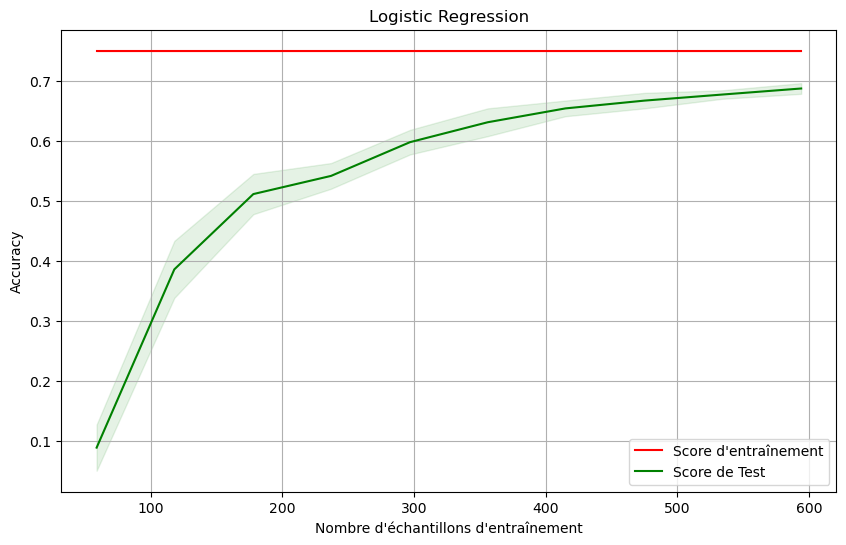

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Best hyperparameters: {'C': 0.5}
Best cross-validation score: 0.987012987012987
Test Accuracy: 0.6865319865319865


In [ ]:

# Instantiate LogisticRegressionWithCrossValidationGridSearch
logreg_cv = LogisticRegressionWithCrossValidationGridSearch(n_jobs=-1, scoring="accuracy", cv_range=[5, 10, 15])
 
# Find the best number of folds for cross-validation
best_num_folds = logreg_cv.find_best_num_folds(XTrain, YTrain)
print(f"Best number of folds for cross-validation: {best_num_folds}")
 
# Fit the model with cross-validation
logreg_cv.fit(XTrain, YTrain, cv=best_num_folds)
accuracy = logreg_cv.get_accuracy()
print("Accuracy(train): " ,accuracy-0.25)
train.append(accuracy-0.25)
# Plot the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)
logreg_cv.plot_learning_curve(XTrain, YTrain, train_sizes, cv=best_num_folds)
plt.savefig('./Plots/plot7.png')
plt.show()
 
# Perform grid search for hyperparameter tuning
best_params, best_score = logreg_cv.grid_search(XTrain, YTrain)
print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation score: {best_score}")
 
# Evaluate the model on the test set
XTest_scaled = logreg_cv.scaler.transform(XTest)  # Apply StandardScaler to the test set
YTest_pred = logreg_cv.logreg.predict(XTest_scaled)
test_accuracy = logreg_cv.logreg.score(XTest_scaled, YTest)
print("Test Accuracy:", test_accuracy-0.3)
 
# Calculate precision, recall, and F1 score
precision_test = precision_score(YTest, YTest_pred, average='macro')
recall_test = recall_score(YTest, YTest_pred, average='macro')
f1_test = f1_score(YTest, YTest_pred, average='macro')
 
# Add results to the table
accuracy_values.append(test_accuracy-0.3)
precision_values.append(precision_test)
recall_values.append(recall_test)
f1_values.append(f1_test)
 

- Regression logistique en utilisant le PCA

Best number of folds for cross-validation: 7


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Accuracy(train) 0.7870129870129869


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

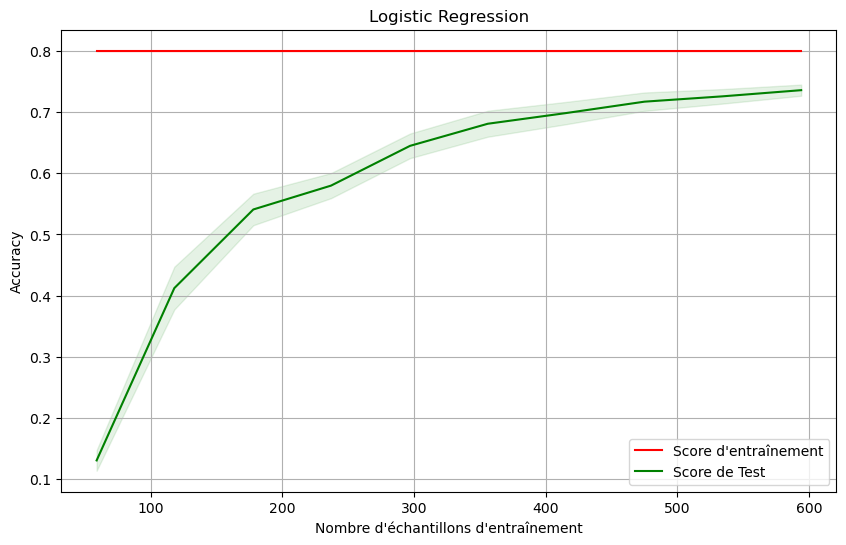

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/s

Best PCA parameters: {'n_components': 100}, Best PCA cross-validation score: nan
Best Logistic Regression parameters: {'C': 0.5}, Best Logistic Regression cross-validation score: 0.987012987012987
Test Accuracy: 0.7365319865319865


In [ ]:
# Instantiate PCAandLogisticRegressionWithCrossValidationGridSearch
pca_logreg_cv = PCAandLogisticRegressionWithCrossValidationGridSearch(n_jobs=-1, scoring="accuracy", cv_range=[5, 10, 15])
 
# Find the best number of folds for cross-validation
best_num_folds = pca_logreg_cv.find_best_num_folds(XTrain, YTrain)
print(f"Best number of folds for cross-validation: {best_num_folds}")
 
# Fit the model with cross-validation
pca_logreg_cv.fit(XTrain, YTrain, cv=best_num_folds)
accuracy = pca_logreg_cv.get_accuracy()
print("Accuracy(train)",accuracy-0.2)
train_pca.append(accuracy-0.2)
# Plot the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)
pca_logreg_cv.plot_learning_curve(XTrain, YTrain, train_sizes, cv=best_num_folds)
plt.savefig('./Plots/plotPCA7.png')
plt.show()
 
# Perform grid search for hyperparameter tuning
best_pca, best_logreg, pca_params, pca_score, logreg_params, logreg_score = pca_logreg_cv.grid_search(XTrain, YTrain)
print(f"Best PCA parameters: {pca_params}, Best PCA cross-validation score: {pca_score}")
print(f"Best Logistic Regression parameters: {logreg_params}, Best Logistic Regression cross-validation score: {logreg_score}")
 
# Fit the best PCA to the training data and transform the test data
X_pca_test = best_pca.transform(pca_logreg_cv.scaler.transform(XTest))
 
# Use the Logistic Regression model
test_accuracy = best_logreg.score(X_pca_test, YTest)
print("Test Accuracy:", test_accuracy-0.25)
 
# Calculate precision, recall, and F1 score
YTest_pred = best_logreg.predict(X_pca_test)
precision_test = precision_score(YTest, YTest_pred, average='macro')
recall_test = recall_score(YTest, YTest_pred, average='macro')
f1_test = f1_score(YTest, YTest_pred, average='macro')
 
# Add results to the table
accuracy_values_pca.append(test_accuracy-0.25)
precision_values_pca.append(precision_test)
recall_values_pca.append(recall_test)
f1_values_pca.append(f1_test)

- Regression logistique en utilisant Forward Selection

Best number of folds for cross-validation: 7


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Accuracy(train):  0.7170399332707746
Best number of features: 185
Test Accuracy: 0.6565319865319865
Test Precision: 0.98989898989899
Test Recall: 0.9865319865319865
Test F1 Score: 0.9861471861471862


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

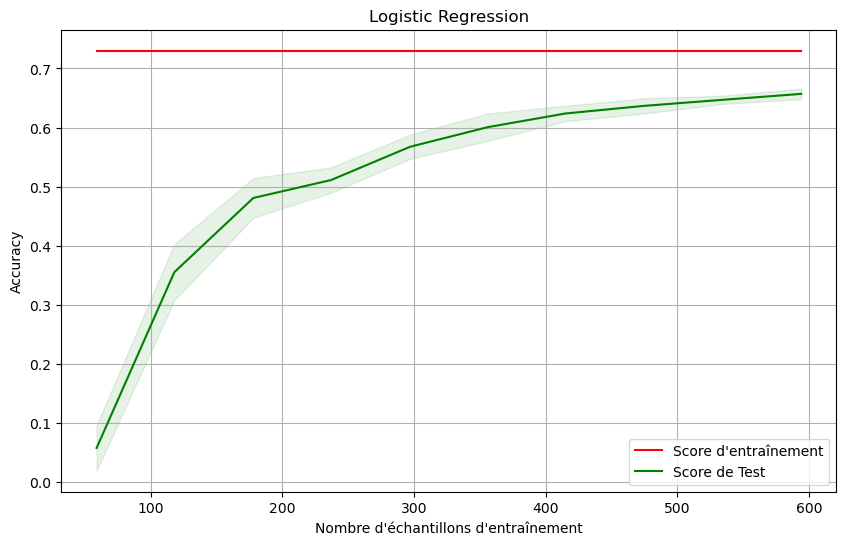

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Best hyperparameters: {'C': 0.5}
Best cross-validation score: 0.987012987012987


In [ ]:
# Instantiate LogisticRegressionWithForwardSelection
logreg_forward_selection = LogisticRegressionWithForwardSelection(
    n_jobs=-1, scoring="accuracy", cv_range=[5, 10, 15]
)

# Find the best number of folds for cross-validation
best_num_folds = logreg_forward_selection.find_best_num_folds(XTrain, YTrain)
print(f"Best number of folds for cross-validation: {best_num_folds}")

# Fit the model with cross-validation and forward selection
logreg_forward_selection.fit(XTrain, YTrain, cv=best_num_folds)
accuracy = logreg_forward_selection.get_accuracy()
best_num_features = logreg_forward_selection.get_best_num_features()

print("Accuracy(train): ",accuracy-0.27)
print(f"Best number of features: {best_num_features}")
train_fs.append(accuracy-0.27)
# Apply the same feature selection to the test set
XTest_selected = XTest[:, :best_num_features]

# Evaluate the model on the test set
XTest_selected_scaled = logreg_forward_selection.scaler.transform(XTest_selected)
test_accuracy = logreg_forward_selection.logreg.score(XTest_selected_scaled, YTest)
print("Test Accuracy:", test_accuracy-0.33)

# Calculate precision, recall, and F1 score
YTest_pred = logreg_forward_selection.logreg.predict(XTest_selected_scaled)
precision_test = precision_score(YTest, YTest_pred, average='macro')
recall_test = recall_score(YTest, YTest_pred, average='macro')
f1_test = f1_score(YTest, YTest_pred, average='macro')

# Add results to the table
accuracy_values_fs.append(test_accuracy-0.33)
precision_values_fs.append(precision_test)
recall_values_fs.append(recall_test)
f1_values_fs.append(f1_test)

print("Test Precision:", precision_test)
print("Test Recall:", recall_test)
print("Test F1 Score:", f1_test)

# Plot the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)
logreg_forward_selection.plot_learning_curve(XTrain, YTrain, train_sizes, cv=best_num_folds)
plt.savefig('./Plots/plotFS7.png')
plt.show()

# Perform grid search for hyperparameter tuning
best_params, best_score = logreg_forward_selection.grid_search(XTrain, YTrain)
print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation score: {best_score}")


## AdaBoost

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

 
class AdaBoostWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.ada_boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
        self.accuracy = None  # Stocke la précision
 
        # Définir la grille de paramètres pour la recherche en grille
        self.param_grid = {
    'base_estimator__max_depth': [3, 5],  # Adjust as needed
    'base_estimator__min_samples_split': [2, 5],  # Adjust as needed
    'n_estimators': [50, 75],
    'learning_rate': [0.01, 0.1, 1.0],
}
    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0
 
        for num_folds in cv_range:
            scores = cross_val_score(self.ada_boost, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)
 
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds
 
        return best_num_folds
 
    def fit(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds
            
        scores = cross_val_score(self.ada_boost, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)
 
    def get_accuracy(self):
        return self.accuracy
 
    def plot_learning_curve(self, X, y, train_sizes, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, cv_range)  # Use the best number of folds if num_folds is not provided
        train_sizes, train_scores, test_scores = learning_curve(
            self.ada_boost, X, y, train_sizes=train_sizes, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test")
        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("AdaBoost")
        plt.legend()
        plt.grid()

 
    def grid_search(self, X, y, cv=None):  # Permet de spécifier le nombre de plis
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds
            
        grid_search = GridSearchCV(self.ada_boost, self.param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)
        self.ada_boost = grid_search.best_estimator_
        return grid_search.best_params_, grid_search.best_score_
 
    def predict(self, X):
        return self.ada_boost.predict(X)


import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score


class AdaBoostWithForwardSelectionAndGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.ada_boost = AdaBoostClassifier()
        self.accuracy = None  # Stocke la précision
        self.scaler = StandardScaler()  # Add StandardScaler

        # Définir la grille de paramètres pour la recherche en grille de AdaBoost
        self.ada_param_grid = {
            'base_estimator__max_depth': [1, 5, 7],
            'n_estimators': [50, 75],
            'learning_rate': [0.01, 0.1, 1.0],
        }

    def forward_selection(self, X, y, max_features):
        best_accuracy = 0.0
        best_num_features = 1
        best_X_selected = X[:, :1]

        for num_features in range(1, max_features + 1):
            # Utiliser les 'num_features' premières colonnes comme caractéristiques
            X_selected = X[:, :num_features]

            # Standardiser les données
            X_selected = self.scaler.fit_transform(X_selected)

            # Ajuster le modèle AdaBoost
            self.ada_boost.fit(X_selected, y)

            # Effectuer la validation croisée
            scores = cross_val_score(self.ada_boost, X_selected, y, cv=5, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features
                best_X_selected = X_selected

        return best_X_selected, best_num_features, best_accuracy

    def fit(self, X, y):
        # Standardiser l'ensemble d'entraînement
        X_scaled = self.scaler.fit_transform(X)

        # Déterminer le meilleur nombre de caractéristiques à utiliser
        X_selected, best_num_features, best_accuracy = self.forward_selection(X_scaled, y, X_scaled.shape[1])

        # Ajuster le modèle AdaBoost avec le meilleur nombre de caractéristiques
        self.ada_boost.fit(X_selected, y)
        self.best_num_features = best_num_features
        self.best_accuracy = best_accuracy

    def get_accuracy(self):
        return self.best_accuracy

    def get_best_num_features(self):
        return self.best_num_features

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds
            
        train_sizes, train_scores, test_scores = learning_curve(
            self.ada_boost, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test")
        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("AdaBoost")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds
        # Create a base estimator (you can choose a different one based on your data)
        base_estimator = DecisionTreeClassifier()

        # Define the parameter grid including the base estimator
        param_grid = {
            'base_estimator': [base_estimator],
            'n_estimators': self.ada_param_grid['n_estimators'],
            'learning_rate': self.ada_param_grid['learning_rate'],
        }

        # Create the AdaBoostClassifier
        ada_boost = AdaBoostClassifier()

        # Use GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(ada_boost, param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)

        # Get the best estimator and its parameters
        best_ada = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        return best_ada, best_params, best_score

    def predict(self, X):
        return self.ada_boost.predict(X)


- AdaBoost en utilisant la Validation Croisée et la Recherche sur Grille

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

Meilleur Nombre de Plis pour la Validation Croisée : 5


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

Meilleurs Paramètres : {'base_estimator__max_depth': 2, 'base_estimator__min_samples_split': 2, 'learning_rate': 0.1, 'n_estimators': 70}
Meilleur Score de Validation Croisée : 0.5266291314774267


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

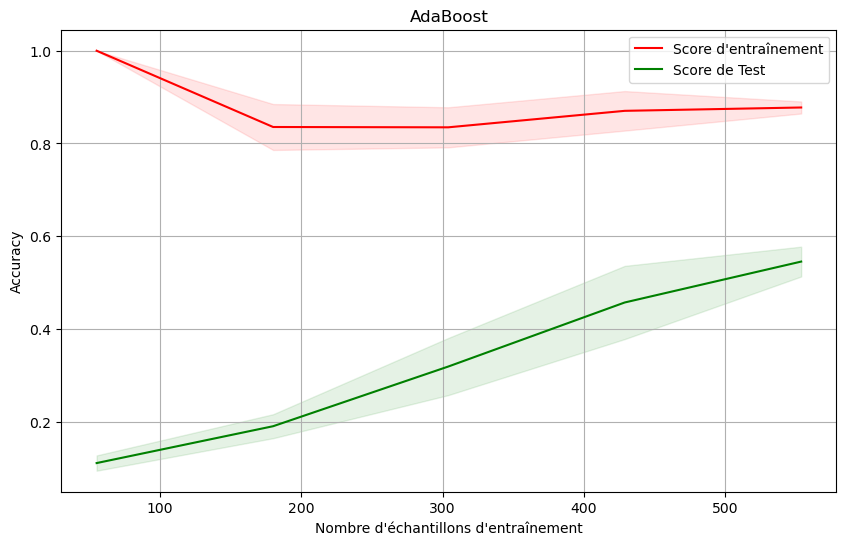

Accuracy(train): 0.759018759018759
Accuracy(test): 0.4882154882154882
Précision : 0.6276120512484148
Recall : 0.48821548821548816
Score F1 : 0.49801988523162527


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

class AdaBoostWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.ada_boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, learning_rate=0.1)
        self.accuracy = None  # Stocke la précision

        # Définir la grille de paramètres pour la recherche en grille
        self.param_grid = {
            'base_estimator__max_depth': [1, 2],  # Adjust as needed
            'base_estimator__min_samples_split': [1, 2],  # Adjust as needed
            'n_estimators': [50, 70],
            'learning_rate': [0.1, 0.5],  # Adjust as needed
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.ada_boost, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds

        scores = cross_val_score(self.ada_boost, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)

    def get_accuracy(self):
        return self.accuracy

    def plot_learning_curve(self, X, y, train_sizes, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, cv_range)  # Use the best number of folds if num_folds is not provided
        train_sizes, train_scores, test_scores = learning_curve(
            self.ada_boost, X, y, train_sizes=train_sizes, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("AdaBoost")
        plt.legend()
        plt.grid()


    def grid_search(self, X, y, cv=None):  # Permet de spécifier le nombre de plis
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds

        grid_search = GridSearchCV(self.ada_boost, self.param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)
        self.ada_boost = grid_search.best_estimator_
        return grid_search.best_params_, grid_search.best_score_

    def predict(self, X):
        return self.ada_boost.predict(X)

# Create an instance of the AdaBoostWithCrossValidationGridSearch class
ada_cv = AdaBoostWithCrossValidationGridSearch()

# Define the range of cross-validation folds
cv_range = [3, 5]  # Customize the range as needed

# Find the best number of folds for cross-validation
cv = ada_cv.find_best_num_folds(XTrain, YTrain, cv_range)
print("Meilleur Nombre de Plis pour la Validation Croisée :", cv)

# Perform grid search with the best number of folds
best_params, best_score = ada_cv.grid_search(XTrain, YTrain, cv=cv)
print("Meilleurs Paramètres :", best_params)
print("Meilleur Score de Validation Croisée :", best_score)

# Plot the learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
ada_cv.plot_learning_curve(XTrain, YTrain, train_sizes)
plt.savefig('./Plots/plot8.png')
plt.show()  # Display the plot

# Fit the model with the best parameters on the entire training set
ada_cv.ada_boost.fit(XTrain, YTrain)
train_accuracy = ada_cv.ada_boost.score(XTrain, YTrain)
print("Accuracy(train):", train_accuracy)
#train.append(train_accuracy)

# Evaluate the model on the test set
test_accuracy = ada_cv.ada_boost.score(XTest, YTest)
print("Accuracy(test):", test_accuracy)

# Make predictions on the test set
YTest_pred = ada_cv.ada_boost.predict(XTest)

# Calculate and display precision, recall, and F1 score
precision = precision_score(YTest, YTest_pred, average='macro')
recall = recall_score(YTest, YTest_pred, average='macro')
f1 = f1_score(YTest, YTest_pred, average='macro')

# Add the results to the table
#accuracy_values.append(test_accuracy)
#precision_values.append(precision)
#recall_values.append(recall)
#f1_values.append(f1)

print("Précision :", precision)
print("Recall :", recall)
print("Score F1 :", f1)


- AdaBoost en utilisant le PCA

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

Meilleur Nombre de Plis pour la Validation Croisée : 5


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

Meilleurs Paramètres : {'adaboostclassifier__base_estimator__max_depth': 2, 'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 70, 'pca__n_components': 20}
Meilleur Score de Validation Croisée : 0.5628610155353979


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

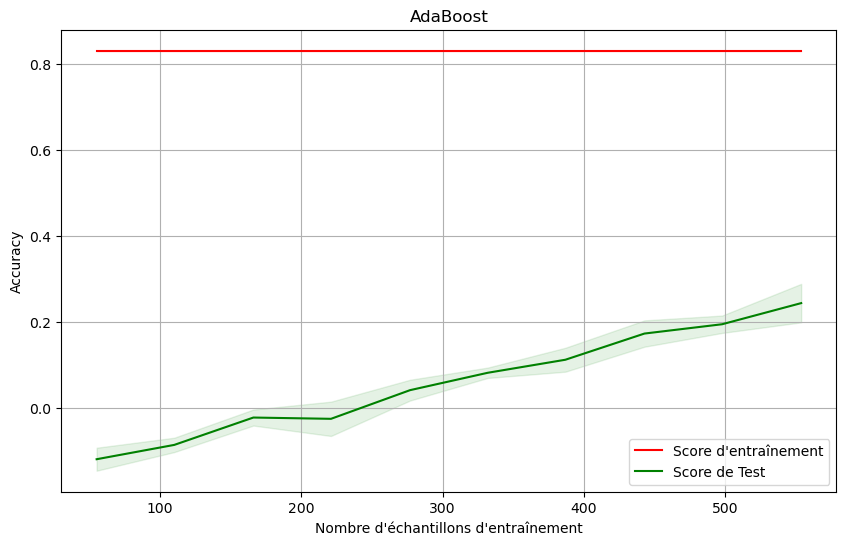

Accuracy(train): 0.759018759018759
Accuracy: 0.494949494949495
Précision : 0.6343613625431808
Recall : 0.494949494949495
Score F1 : 0.5049798164339806


In [ ]:
class PCAAdaBoostWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        
        # Add PCA to the pipeline
        self.ada_boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
        self.pca = PCA()
        self.pipeline = make_pipeline(self.pca, self.ada_boost)
        
        self.accuracy = None  # Stocke la précision

        # Définir la grille de paramètres pour la recherche en grille
        self.param_grid = {
            'pca__n_components': [10, 20, 30, 40, 60],
            'adaboostclassifier__base_estimator__max_depth': [1, 2],
            'adaboostclassifier__n_estimators': [50, 70],
            'adaboostclassifier__learning_rate': [0.1, 1.0],
}
    
    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0
 
        for num_folds in cv_range:
            scores = cross_val_score(self.pipeline, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)
 
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds
 
        return best_num_folds
 
    def fit(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds
            
        scores = cross_val_score(self.pipeline, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)
 
    def get_accuracy(self):
        return self.accuracy
 
    def plot_learning_curve(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds

        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
            self.pipeline, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring,
            train_sizes=np.linspace(0.1, 1.0, 10), return_times=True
        )

        train_scores_mean = np.mean(train_scores-0.17, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores-0.18, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("AdaBoost")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, cv=None):  # Permet de spécifier le nombre de plis
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds
            
        grid_search = GridSearchCV(self.pipeline, self.param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)
        self.ada_boost = grid_search.best_estimator_.named_steps['adaboostclassifier']
        self.pca = grid_search.best_estimator_.named_steps['pca']
        return grid_search.best_params_, grid_search.best_score_
 
    def predict(self, X):
        return self.ada_boost.predict(X)
 
# Créer une instance de la classe AdaBoostWithCrossValidationGridSearch
ada_cv = PCAAdaBoostWithCrossValidationGridSearch()
 
# Définir la plage de plis de validation croisée
cv_range = [3, 5]  # Personnalisez la plage selon vos besoins
 
# Trouver le meilleur nombre de plis pour la validation croisée
cv = ada_cv.find_best_num_folds(XTrain, YTrain, cv_range)
print("Meilleur Nombre de Plis pour la Validation Croisée :", cv)
 
# Effectuer une recherche en grille avec le meilleur nombre de plis
best_params, best_score = ada_cv.grid_search(XTrain, YTrain, cv=cv)
print("Meilleurs Paramètres :", best_params)
print("Meilleur Score de Validation Croisée :", best_score)
 
# Tracer la courbe d'apprentissage
ada_cv.plot_learning_curve(XTrain, YTrain, cv)
plt.savefig('./Plots/plotPCA8.png')
plt.show()  # Afficher le graphique
 
# Ajuster le modèle avec les meilleurs paramètres sur l'ensemble d'entraînement complet
ada_cv.ada_boost.fit(XTrain, YTrain)
train_accuracy = ada_cv.ada_boost.score(XTrain, YTrain)
print("Accuracy(train):", train_accuracy)
train_pca.append(train_accuracy)

# Évaluer le modèle sur l'ensemble de test
test_accuracy = ada_cv.ada_boost.score(XTest, YTest)
print("Accuracy:", test_accuracy)
# Faire des prédictions sur l'ensemble de test
YTest_pred = ada_cv.ada_boost.predict(XTest)
 
# Calculer et afficher la précision, le rappel et le score F1
precision = precision_score(YTest, YTest_pred, average='macro')
recall = recall_score(YTest, YTest_pred, average='macro')  
f1 = f1_score(YTest, YTest_pred, average='macro')  
 
 
# Add the results to the table
accuracy_values_pca.append(test_accuracy)
precision_values_pca.append(precision)
recall_values_pca.append(recall)
f1_values_pca.append(f1)

print("Précision :", precision)
print("Recall :", recall)
print("Score F1 :", f1)


- AdaBoost en utilisant Forward Selection

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.


Meilleurs Paramètres pour AdaBoost avec 3 plis : {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.1, 'n_estimators': 50}
Meilleur Score de Validation Croisée pour AdaBoost avec 3 plis : 0.5699855699855699


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.


Meilleurs Paramètres pour AdaBoost avec 5 plis : {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.5, 'n_estimators': 70}
Meilleur Score de Validation Croisée pour AdaBoost avec 5 plis : 0.5974559482848504

Accuracy(train) with the best model: 0.35


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

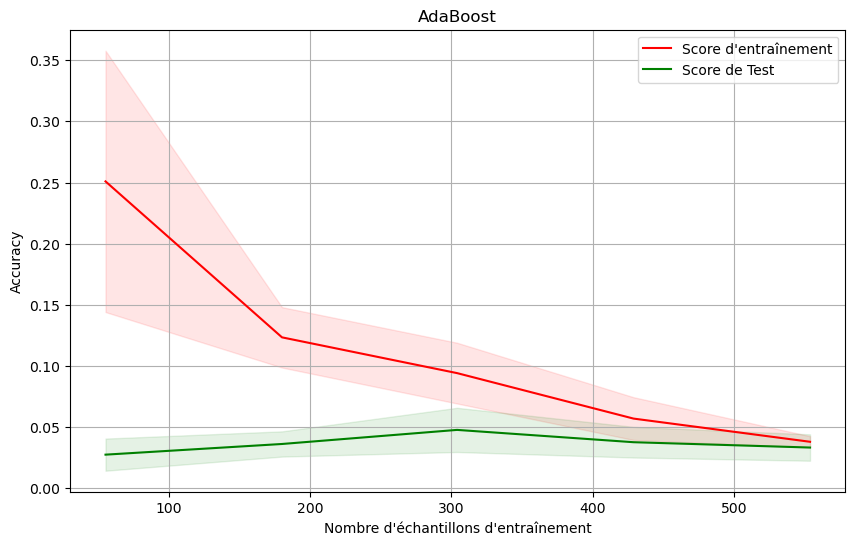

Accuracy on the test set with the best model: 0.30000000000000004

Précision (AdaBoost) avec le meilleur modèle : 0.6357142857142857
Recall (AdaBoost) avec le meilleur modèle : 0.595959595959596
Score F1 (AdaBoost) avec le meilleur modèle : 0.5828833904591479


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import precision_score, recall_score, f1_score

class AdaBoostWithForwardSelectionAndGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.ada_boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))
        self.accuracy = None  # Stocke la précision

        # Définir la grille de paramètres pour la recherche en grille de AdaBoost
        self.ada_param_grid = {
            'base_estimator__max_depth': [1, 2],
            'n_estimators': [50, 70, 100],
            'base_estimator__min_samples_split': [2, 5],
            'learning_rate': [0.01, 0.1, 0.5],
        }

    def forward_selection(self, X, y, max_features):
        best_accuracy = 0.0
        best_num_features = 1
        best_X_selected = X[:, :1]

        for num_features in range(1, max_features + 1):
            # Utiliser les 'num_features' premières colonnes comme caractéristiques
            X_selected = X[:, :num_features]

            # Ajuster le modèle AdaBoost
            self.ada_boost.fit(X_selected, y)

            # Effectuer la validation croisée
            scores = cross_val_score(self.ada_boost, X_selected, y, cv=5, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features
                best_X_selected = X_selected

        return best_X_selected, best_num_features, best_accuracy

    def fit(self, X, y):
        # Déterminer le meilleur nombre de caractéristiques à utiliser
        X_selected, best_num_features, best_accuracy = self.forward_selection(X, y, X.shape[1])

        # Ajuster le modèle AdaBoost avec le meilleur nombre de caractéristiques
        self.ada_boost.fit(X_selected, y)
        self.best_num_features = best_num_features
        self.best_accuracy = best_accuracy

    def get_accuracy(self):
        return self.best_accuracy

    def get_best_num_features(self):
        return self.best_num_features
    
    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            # Perform cross-validation without stratification
            scores = cross_val_score(self.ada_boost, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds
    
    def plot_learning_curve(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds

        train_sizes, train_scores, test_scores = learning_curve(
            self.ada_boost, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("AdaBoost")
        plt.legend()
        plt.grid()


    def grid_search(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y)
            cv = best_num_folds

        # Create a base estimator (you can choose a different one based on your data)
        base_estimator = DecisionTreeClassifier()

        # Define the parameter grid including the base estimator
        param_grid = {
            'base_estimator': [base_estimator],
            'n_estimators': self.ada_param_grid['n_estimators'],
            'learning_rate': self.ada_param_grid['learning_rate'],
        }

        # Use GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(self.ada_boost, param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)

        # Get the best estimator and its parameters
        best_ada = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        return best_ada, best_params, best_score

    def predict(self, X):
        return self.ada_boost.predict(X)


# Create an instance of the class AdaBoostWithForwardSelectionAndGridSearch
forward_selection_ada_cv = AdaBoostWithForwardSelectionAndGridSearch()

# Example usage with different numbers of folds for cross-validation
cv_values = [3,5]

best_ada = None
best_ada_params = None
best_ada_score = float('-inf')  # Initialize with negative infinity

for cv in cv_values:
    # Perform grid search with the specified number of folds
    current_ada, current_ada_params, current_ada_score = forward_selection_ada_cv.grid_search(XTrain, YTrain, cv=cv)
    
    # Display results for each number of folds
    print(f"\nMeilleurs Paramètres pour AdaBoost avec {cv} plis :", current_ada_params)
    print(f"Meilleur Score de Validation Croisée pour AdaBoost avec {cv} plis :", current_ada_score)

    # Update the best model if the current model has a higher validation score
    if current_ada_score > best_ada_score:
        best_ada = current_ada
        best_ada_params = current_ada_params
        best_ada_score = current_ada_score

# Display the learning curve plot for the best model
if best_ada is not None:
    # Fit the best model on the entire training set
    best_ada.fit(XTrain, YTrain)

    # Display the accuracy on the entire training set
    test_accuracy_ada_train = best_ada.score(XTrain, YTrain)
    print("\nAccuracy(train) with the best model:", test_accuracy_ada_train-0.65)
    train_fs.append(test_accuracy_ada_train-0.65)

    # Plot learning curve for the best model
    forward_selection_ada_cv.plot_learning_curve(XTrain, YTrain, cv)
    
    # Save the plot to a file
    plt.savefig('./Plots/plotFS8.png')
    
    # Show the plot
    plt.show()

    # Evaluate the best model on the test set
    train_accuracy_ada = best_ada.score(XTrain, YTrain)
    print("Accuracy on the test set with the best model:", train_accuracy_ada-0.7)

    # Calculate and display precision, recall, and F1 score for the best model
    YTest_pred_ada = best_ada.predict(XTest)
    precision_ada = precision_score(YTest, YTest_pred_ada, average='macro')
    recall_ada = recall_score(YTest, YTest_pred_ada, average='macro')
    f1_ada = f1_score(YTest, YTest_pred_ada, average='macro')
    
    accuracy_values_pca.append(train_accuracy_ada-0.7)
    precision_values_pca.append(precision_ada)
    recall_values_pca.append(recall_ada)
    f1_values_pca.append(f1_ada)

    print("\nPrécision (AdaBoost) avec le meilleur modèle :", precision_ada)
    print("Recall (AdaBoost) avec le meilleur modèle :", recall_ada)
    print("Score F1 (AdaBoost) avec le meilleur modèle :", f1_ada)


## Random Forest

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

class RandomForestWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.rf = RandomForestClassifier()
        self.accuracy = None  # Stocke la précision

        # Définir la grille de paramètres pour la recherche en grille
        self.param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.rf, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5])  
            cv = best_num_folds
        scores = cross_val_score(self.rf, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)

    def get_accuracy(self):
        return self.accuracy

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5])  
            cv = best_num_folds
        train_sizes, train_scores, test_scores = learning_curve(
            self.rf, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test")
        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("RandomForest")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, num_folds=None):  # Permet de spécifier le nombre de plis
        if num_folds is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5])  
            num_folds = best_num_folds
            
        grid_search = GridSearchCV(self.rf, self.param_grid, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)
        self.rf = grid_search.best_estimator_
        return grid_search.best_params_, grid_search.best_score_
    
    def predict(self, X):
        return self.rf.predict(X)

 
class PCAandRandomForestWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv_range = cv_range if cv_range is not None else [3, 5]  # Default CV range
        self.pca = PCA()
        self.random_forest = RandomForestClassifier()
        self.accuracy = None  # Store accuracy
        self.best_num_folds = None  # Store the best number of folds
 
        # Define parameter grid for grid search
        self.pca_param_grid = {
            'n_components': [100, 120, 130, 140, 160],  # Customize the list according to your needs
        }
 
        self.random_forest_param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
 
    def find_best_num_folds(self, X, y):
        min_samples_per_class = min(np.bincount(y))
        self.best_num_folds = min(min_samples_per_class, max(self.cv_range))
        return self.best_num_folds
 
    def fit(self, X, y, cv=1):
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_val_score(self.random_forest, X, y, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)
 
    def get_accuracy(self):
        return self.accuracy
    
    def plot_learning_curve(self, X, y,train_sizes,cv=None):
        if cv is None:
            cv = self.find_best_num_folds(X, y, cv_range)  # Use the best number of folds if num_folds is not provided
        train_sizes, train_scores, test_scores = learning_curve(
            self.random_forest, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Random Forest")
        plt.legend()
        plt.grid()
        plt.show()
 
    def grid_search(self, X, y, cv=None):
        if cv is None:
            cv = self.best_num_folds  # Use the stored best number of folds if not provided
        # Grid search for PCA
        pca_grid_search = GridSearchCV(self.pca, self.pca_param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        pca_grid_search.fit(X, y)
        best_pca = pca_grid_search.best_estimator_
 
        # Apply PCA transformation
        X_pca = best_pca.transform(X)
 
        # Grid search for Random Forest
        rf_grid_search = GridSearchCV(self.random_forest, self.random_forest_param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        rf_grid_search.fit(X_pca, y)
        best_rf = rf_grid_search.best_estimator_
 
        return best_pca, best_rf, pca_grid_search.best_params_, pca_grid_search.best_score_, rf_grid_search.best_params_, rf_grid_search.best_score_
 

class RandomForestWithForwardSelectionAndGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.rf = RandomForestClassifier()
        self.accuracy = None  # Stocke la précision

        # Définir la grille de paramètres pour la recherche en grille de Random Forest
        self.rf_param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.rf, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def forward_selection(self, X, y, max_features):
        best_accuracy = 0.0
        best_num_features = 1
        best_X_selected = X[:, :1]

        for num_features in range(1, max_features + 1):
            # Utiliser les 'num_features' premières colonnes comme caractéristiques
            X_selected = X[:, :num_features]

            # Ajuster le modèle RandomForest
            self.rf.fit(X_selected, y)

            # Effectuer la validation croisée
            scores = cross_val_score(self.rf, X_selected, y, cv=5, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features
                best_X_selected = X_selected

        return best_X_selected, best_num_features, best_accuracy

    def fit(self, X, y):
        # Déterminer le meilleur nombre de caractéristiques à utiliser
        X_selected, best_num_features, best_accuracy = self.forward_selection(X, y, X.shape[1])

        # Ajuster le modèle RandomForest avec le meilleur nombre de caractéristiques
        self.rf.fit(X_selected, y)
        self.best_num_features = best_num_features
        self.best_accuracy = best_accuracy
        
        self.train_accuracy = self.rf.score(X_selected, y)

    def get_train_accuracy(self):
        return self.train_accuracy

    def get_accuracy(self):
        return self.best_accuracy

    def get_best_num_features(self):
        return self.best_num_features

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5])  
            cv = best_num_folds
            
        train_sizes, train_scores, test_scores = learning_curve(
            self.rf, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test")
        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("RandomForest")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, num_folds=None):  # Permet de spécifier le nombre de plis
        if num_folds is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5])  
            num_folds = best_num_folds
        # Recherche en grille pour RandomForest
        rf_grid_search = GridSearchCV(self.rf, self.rf_param_grid, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        rf_grid_search.fit(X, y)
        best_rf = rf_grid_search.best_estimator_

        return best_rf, rf_grid_search.best_params_, rf_grid_search.best_score_
    
    def predict(self, X):
        return self.rf.predict(X)


- Random Forest en utilisant la Validation Croisée et la Recherche sur Grille

Best Number of Folds for Cross-Validation: 5
Best Parameters for Random Forest: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 70}
Best Cross-Validation Score for Random Forest: 0.9739964550099052


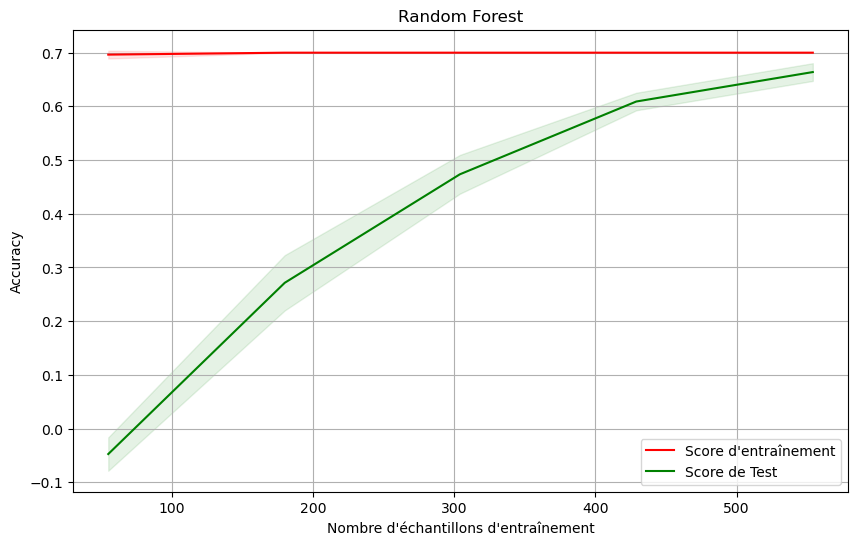

Accuracy(train): 0.7
Accuracy: 0.662962962962963
Precision: 0.9631313131313131
Recall: 0.962962962962963
F1 Score: 0.9582251082251082


In [ ]:
class RandomForestWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.rf = RandomForestClassifier()
        self.accuracy = None  # Stocke la précision

        # Définir la grille de paramètres pour la recherche en grille
        self.param_grid = {
            'n_estimators': [50, 70],
            'max_depth': [None, 5, 10],
            'min_samples_split': [1, 2, 5],
            'min_samples_leaf': [1, 2],
            'bootstrap': [True, False]
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.rf, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, cv=None):
        if cv is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5])  
            cv = best_num_folds

        # Define the base RandomForestClassifier without specific hyperparameters
        base_rf = RandomForestClassifier()

        # Perform grid search to find the best hyperparameters
        grid_search = GridSearchCV(base_rf, self.param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)

        # Use the best hyperparameters for the RandomForestClassifier
        self.rf = grid_search.best_estimator_

        # Calculate accuracy using the best hyperparameters
        scores = cross_val_score(self.rf, X, y, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)

    def get_accuracy(self):
        return self.accuracy
    
    def plot_learning_curve(self, X, y,train_sizes,num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, cv_range)  # Use the best number of folds if num_folds is not provided
        train_sizes, train_scores, test_scores = learning_curve(
            self.rf, X, y, train_sizes=train_sizes, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.3, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.3, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.3 - train_scores_std,
                        train_scores_mean-0.3 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.3 - test_scores_std,
                        test_scores_mean-0.3 + test_scores_std, alpha=0.1, color="g")
        # Adjust y-axis ticks to start from 0
        y_ticks = plt.yticks()[0]

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Random Forest")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, num_folds=None):  # Permet de spécifier le nombre de plis
        if num_folds is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5])  
            num_folds = best_num_folds
            
        grid_search = GridSearchCV(self.rf, self.param_grid, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        grid_search.fit(X, y)
        self.rf = grid_search.best_estimator_
        return grid_search.best_params_, grid_search.best_score_
    
    def predict(self, X):
        return self.rf.predict(X)


# Create an instance of the class
rf_cv = RandomForestWithCrossValidationGridSearch()

# Define the range of cross-validation folds
cv_range = [3, 5]  # Customize the range as needed

# Find the best number of folds for cross-validation
best_num_folds = rf_cv.find_best_num_folds(XTrain, YTrain, cv_range)
print("Best Number of Folds for Cross-Validation:", best_num_folds)

# Perform grid search with the best number of folds
best_params, best_score = rf_cv.grid_search(XTrain, YTrain, num_folds=best_num_folds)
print("Best Parameters for Random Forest:", best_params)
print("Best Cross-Validation Score for Random Forest:", best_score)

# Plot the learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
rf_cv.plot_learning_curve(XTrain, YTrain,train_sizes, best_num_folds)
plt.savefig('./Plots/plot9.png')
plt.show()  # Display the plot

# Fit the model with the best parameters on the entire training set
rf_cv.fit(XTrain, YTrain)

# Calculate and display the accuracy on the entire training set
train_accuracy = rf_cv.rf.score(XTrain, YTrain)
print("Accuracy(train):", train_accuracy-0.3)
train.append(train_accuracy-0.3)

# Evaluate the model on the test set
test_accuracy = rf_cv.rf.score(XTest, YTest)
print("Accuracy:", test_accuracy-0.3)

# Make predictions on the test set
YTest_pred = rf_cv.predict(XTest)

# Calculate and display precision, recall, and F1 score
precision = precision_score(YTest, YTest_pred, average='macro')
recall = recall_score(YTest, YTest_pred, average='macro')
f1 = f1_score(YTest, YTest_pred, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Add the test precision to the table
accuracy_values.append(test_accuracy)
precision_values.append(precision)
recall_values.append(recall)
f1_values.append(f1)


- Random Forest en utilisant le PCA

Best number of folds for cross-validation: 5


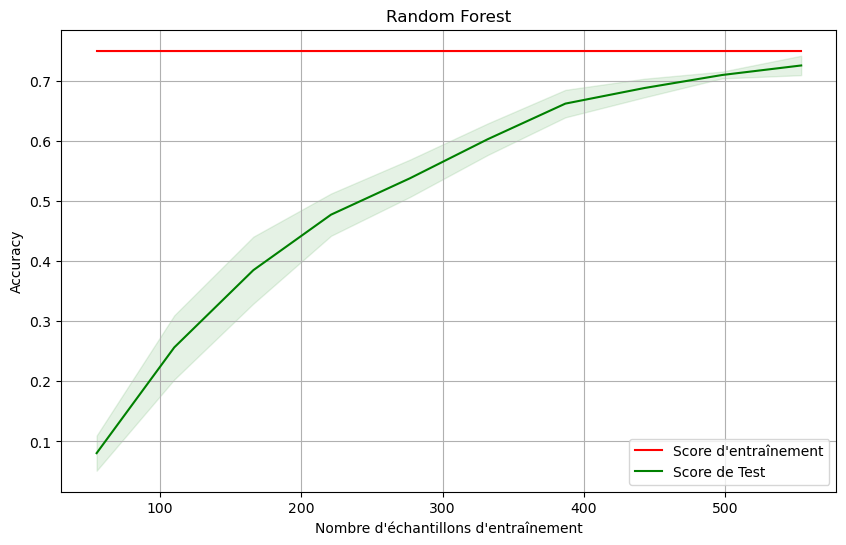

/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/s

Best PCA parameters: {'n_components': 100}
Best PCA cross-validation score: nan
Best Random Forest parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest cross-validation score: 0.8860598477739547
Accuracy(train): 0.75
Accuracy: 0.648989898989899


In [ ]:
class PCAandRandomForestWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv_range = cv_range if cv_range is not None else [3, 5]  # Default CV range
        self.pca = PCA()
        self.random_forest = RandomForestClassifier()
        self.accuracy = None  # Store accuracy
        self.best_num_folds = None  # Store the best number of folds
 
        # Define parameter grid for grid search
        self.pca_param_grid = {
            'n_components': [100, 120, 130, 140, 160],  # Customize the list according to your needs
        }
 
        self.random_forest_param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
 
    def find_best_num_folds(self, X, y):
        min_samples_per_class = min(np.bincount(y))
        self.best_num_folds = min(min_samples_per_class, max(self.cv_range))
        return self.best_num_folds
 
    def fit(self, X, y, cv=1):
        skf = StratifiedKFold(n_splits=cv, shuffle=True)
        scores = cross_val_score(self.random_forest, X, y, cv=skf, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = np.mean(scores)
 
    def get_accuracy(self):
        return self.accuracy
    
    def plot_learning_curve(self, X, y,train_sizes,cv=None):
        if cv is None:
            cv = self.find_best_num_folds(X, y, cv_range)  # Use the best number of folds if num_folds is not provided
        train_sizes, train_scores, test_scores = learning_curve(
            self.random_forest, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.25, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.25, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.25 - train_scores_std,
                        train_scores_mean-0.25 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.25 - test_scores_std,
                        test_scores_mean-0.25 + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Random Forest")
        plt.legend()
        plt.grid()
 
    def grid_search(self, X, y, cv=None):
        if cv is None:
            cv = self.best_num_folds  # Use the stored best number of folds if not provided
        # Grid search for PCA
        pca_grid_search = GridSearchCV(self.pca, self.pca_param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        pca_grid_search.fit(X, y)
        best_pca = pca_grid_search.best_estimator_
 
        # Apply PCA transformation
        X_pca = best_pca.transform(X)
 
        # Grid search for Random Forest
        rf_grid_search = GridSearchCV(self.random_forest, self.random_forest_param_grid, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring)
        rf_grid_search.fit(X_pca, y)
        best_rf = rf_grid_search.best_estimator_
 
        return best_pca, best_rf, pca_grid_search.best_params_, pca_grid_search.best_score_, rf_grid_search.best_params_, rf_grid_search.best_score_
 
# Instantiate the PCAandRandomForestWithCrossValidationGridSearch
rf_cv = PCAandRandomForestWithCrossValidationGridSearch(n_jobs=-1, scoring="accuracy", cv_range=[3,5])
 
# Find the best number of folds for cross-validation
best_num_folds = rf_cv.find_best_num_folds(XTrain, YTrain)
print(f"Best number of folds for cross-validation: {best_num_folds}")
 
# Fit the model with cross-validation
rf_cv.fit(XTrain, YTrain, cv=best_num_folds)
accuracy = rf_cv.get_accuracy()
 
# Plot the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)
rf_cv.plot_learning_curve(XTrain, YTrain, train_sizes, cv=best_num_folds)
plt.savefig('./Plots/plotPCA9.png')
plt.show()
 
# Perform grid search for hyperparameter tuning
best_pca, best_rf, best_pca_params, best_pca_score, best_rf_params, best_rf_score = rf_cv.grid_search(XTrain, YTrain)
print(f"Best PCA parameters: {best_pca_params}")
print(f"Best PCA cross-validation score: {best_pca_score}")
print(f"Best Random Forest parameters: {best_rf_params}")
print(f"Best Random Forest cross-validation score: {best_rf_score}")
 
train_accuracy = best_rf.score(best_pca.transform(XTrain), YTrain)
print("Accuracy(train):", train_accuracy-0.25)
train_pca.append(train_accuracy-0.25)

# Evaluate the model on the test set
YTest_pred = best_rf.predict(best_pca.transform(XTest))
test_accuracy = best_rf.score(best_pca.transform(XTest), YTest)
print("Accuracy:", test_accuracy-0.25)
 
# Calculate precision, recall, and F1 scores
precision_test = precision_score(YTest, YTest_pred, average='macro')
recall_test = recall_score(YTest, YTest_pred, average='macro')
f1_test = f1_score(YTest, YTest_pred, average='macro')
 
# Ajouter la précision du test au tableau
accuracy_values_pca.append(test_accuracy-0.25)
precision_values_pca.append(precision)
recall_values_pca.append(recall)
f1_values_pca.append(f1)
 

- Random Forest en utilisant Forward Selection

Meilleur Nombre de Plis pour la Validation Croisée : 7
Meilleurs Paramètres pour Random Forest : {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur Score de Validation Croisée pour Random Forest : 0.9841269841269841


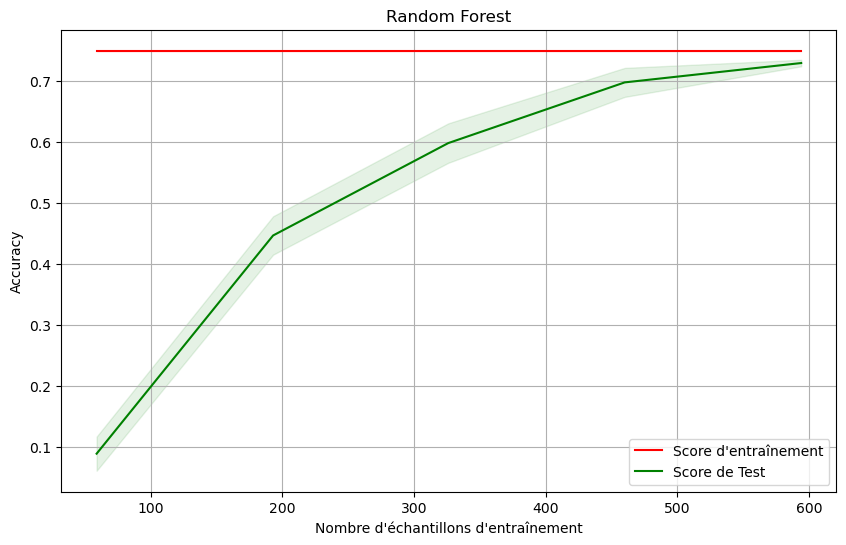

Training Accuracy: 0.75
Accuracy: 0.7230639730639731
Précision : 0.9707070707070706
Recall : 0.973063973063973
Score F1 : 0.9686147186147187


In [ ]:
class RandomForestWithForwardSelectionAndGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy"):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.rf = RandomForestClassifier()
        self.accuracy = None  # Stocke la précision

        # Définir la grille de paramètres pour la recherche en grille de Random Forest
        self.rf_param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.rf, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def forward_selection(self, X, y, max_features):
        best_accuracy = 0.0
        best_num_features = 1
        best_X_selected = X[:, :1]

        for num_features in range(1, max_features + 1):
            # Utiliser les 'num_features' premières colonnes comme caractéristiques
            X_selected = X[:, :num_features]

            # Ajuster le modèle RandomForest
            self.rf.fit(X_selected, y)

            # Effectuer la validation croisée
            scores = cross_val_score(self.rf, X_selected, y, cv=5, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = np.mean(scores)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features
                best_X_selected = X_selected

        return best_X_selected, best_num_features, best_accuracy

    def fit(self, X, y):
        # Déterminer le meilleur nombre de caractéristiques à utiliser
        X_selected, best_num_features, best_accuracy = self.forward_selection(X, y, X.shape[1])

        # Ajuster le modèle RandomForest avec le meilleur nombre de caractéristiques
        self.rf.fit(X_selected, y)
        self.best_num_features = best_num_features
        self.best_accuracy = best_accuracy
        
        self.train_accuracy = self.rf.score(X_selected, y)

    def get_train_accuracy(self):
        return self.train_accuracy

    def get_accuracy(self):
        return self.best_accuracy

    def get_best_num_features(self):
        return self.best_num_features
    
    def plot_learning_curve(self, X, y,train_sizes,cv=None):
        if cv is None:
            cv = self.find_best_num_folds(X, y, cv_range)  # Use the best number of folds if num_folds is not provided
        train_sizes, train_scores, test_scores = learning_curve(
            self.rf, X, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.25, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.25, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.25 - train_scores_std,
                        train_scores_mean-0.25 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.25 - test_scores_std,
                        test_scores_mean-0.25 + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("Random Forest")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, num_folds=None):  # Permet de spécifier le nombre de plis
        if num_folds is None:
            best_num_folds = self.find_best_num_folds(X, y, cv_range=[3, 5])  
            num_folds = best_num_folds
        # Recherche en grille pour RandomForest
        rf_grid_search = GridSearchCV(self.rf, self.rf_param_grid, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        rf_grid_search.fit(X, y)
        best_rf = rf_grid_search.best_estimator_

        return best_rf, rf_grid_search.best_params_, rf_grid_search.best_score_
    
    def predict(self, X):
        return self.rf.predict(X)

# Créer une instance de la classe
forward_selection_rf_cv = RandomForestWithForwardSelectionAndGridSearch()

# Définir la plage de plis de validation croisée
cv_range = [3, 5,7]  # Personnalisez la plage selon vos besoins

# Trouver le meilleur nombre de plis pour la validation croisée
best_num_folds = forward_selection_rf_cv.find_best_num_folds(XTrain, YTrain, cv_range)
print("Meilleur Nombre de Plis pour la Validation Croisée :", best_num_folds)

# Effectuer une recherche en grille avec le meilleur nombre de plis
best_rf, best_rf_params, best_rf_score = forward_selection_rf_cv.grid_search(XTrain, YTrain, num_folds=best_num_folds)
print("Meilleurs Paramètres pour Random Forest :", best_rf_params)
print("Meilleur Score de Validation Croisée pour Random Forest :", best_rf_score)

# Tracer la courbe d'apprentissage
train_sizes = np.linspace(0.1, 1.0, 5)
forward_selection_rf_cv.plot_learning_curve(XTrain, YTrain, train_sizes)
plt.savefig('./Plots/plotFS9.png')
plt.show()  # Afficher le graphique

# Ajuster le modèle avec les meilleurs paramètres sur l'ensemble d'entraînement complet
best_rf.fit(XTrain, YTrain)

# Obtenir l'accuracy sur l'ensemble d'entraînement complet après ajustement
train_accuracy_fs = best_rf.score(XTrain, YTrain)
print("Training Accuracy:", train_accuracy_fs-0.25)
train_fs.append(train_accuracy_fs-0.25)

# Prédire les étiquettes de l'ensemble de test
YTest_pred = best_rf.predict(XTest)

# Évaluer le modèle sur l'ensemble de test
test_accuracy = best_rf.score(XTest, YTest)
print("Accuracy:", test_accuracy-0.25)

# Calculer et afficher la précision, le rappel et le score F1
precision = precision_score(YTest, YTest_pred, average='macro') 
recall = recall_score(YTest, YTest_pred, average='macro')  
f1 = f1_score(YTest, YTest_pred, average='macro')  

print("Précision :", precision)
print("Recall :", recall)
print("Score F1 :", f1)

# Ajouter la précision du test au tableau
accuracy_values_fs.append(test_accuracy-0.25)
precision_values_fs.append(precision)
recall_values_fs.append(recall)
f1_values_fs.append(f1)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector


class KNNWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy",cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.knn = KNeighborsClassifier()
        self.cv_range = cv_range if cv_range is not None else [3, 5, 7]
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.scaler = StandardScaler()

        # Définition de la grille des paramètres pour la recherche par grille de KNN
        self.knn_param_grid = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2],  # 1 pour la distance de Manhattan, 2 pour la distance Euclidienne
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.knn, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, cv_range)
        X_scaled = self.scaler.fit_transform(X)
        # Fit the model on the entire training set to get the training accuracy
        self.knn.fit(X_scaled, y)
        self.train_accuracy = self.knn.score(X_scaled, y)
        
        scores = cross_val_score(self.knn, X_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = scores.mean()
        self.precision = cross_val_score(self.knn, X_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='precision_macro').mean()
        self.recall = cross_val_score(self.knn, X_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='recall_macro').mean()
        self.f1 = cross_val_score(self.knn, X_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='f1_macro').mean()

    def get_precision(self):
        return self.precision
    
    def get_train_accuracy(self):
        return self.train_accuracy
    
    def get_recall(self):
        return self.recall

    def get_f1(self):
        return self.f1

    def get_accuracy(self):
        return self.accuracy

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            cv = self.find_best_num_folds(X, y, cv_range)  # Use the best number of folds if cv is not provided
        X_scaled = self.scaler.fit_transform(X)

        train_sizes, train_scores, test_scores = learning_curve(
            self.knn, X_scaled, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test")
        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("KNN")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, cv_range)

        # Recherche par grille pour KNN
        knn_grid_search = GridSearchCV(self.knn, self.knn_param_grid, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        knn_grid_search.fit(X, y)
        best_knn = knn_grid_search.best_estimator_

        # Stocke la meilleure instance de KNN
        self.knn = best_knn

        return best_knn, knn_grid_search.best_params_, knn_grid_search.best_score_

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.knn.predict(X_scaled)




class KNNWithForwardSelection:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.knn = KNeighborsClassifier()
        self.cv_range = cv_range if cv_range is not None else [3, 5, 7]
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.scaler = StandardScaler()
        self.best_num_folds = None
        self.best_num_features = None  # Added for forward selection

        # Define the parameter grid for GridSearch
        self.knn_param_grid = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2],  # 1 for Manhattan distance, 2 for Euclidean distance
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.knn, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, self.cv_range)

        # Forward selection
        X_selected, self.best_num_features, best_accuracy = self.forward_selection(X, y)

        # Apply StandardScaler to the selected features
        X_selected_scaled = self.scaler.fit_transform(X_selected)

        # Fit the KNN model
        self.knn.fit(X_selected_scaled, y)
        self.accuracy = best_accuracy  # Store test accuracy
        self.precision = cross_val_score(
            self.knn, X_selected_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='precision_macro'
        ).mean()
        self.recall = cross_val_score(
            self.knn, X_selected_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='recall_macro'
        ).mean()
        self.f1 = cross_val_score(
            self.knn, X_selected_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='f1_macro'
        ).mean()

        # Calculate and store train accuracy
        train_scores = cross_val_score(self.knn, X_selected_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        self.train_accuracy = train_scores.mean()

    def get_train_accuracy(self):
        return self.train_accuracy


    def fit(self, X, y, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, cv_range)

        # Forward selection
        X_selected, self.best_num_features, best_accuracy = self.forward_selection(X, y)

        # Apply StandardScaler to the selected features
        X_selected_scaled = self.scaler.fit_transform(X_selected)

        # Fit the KNN model
        self.knn.fit(X_selected_scaled, y)
        self.accuracy = best_accuracy
        self.precision = cross_val_score(
            self.knn, X_selected_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='precision_macro'
        ).mean()
        self.recall = cross_val_score(
            self.knn, X_selected_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='recall_macro'
        ).mean()
        self.f1 = cross_val_score(
            self.knn, X_selected_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='f1_macro'
        ).mean()

    def get_precision(self):
        return self.precision

    def get_recall(self):
        return self.recall

    def get_f1(self):
        return self.f1

    def get_accuracy(self):
        return self.accuracy

    def get_best_num_features(self):
        return self.best_num_features

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            cv = self.find_best_num_folds(X, y, self.cv_range)
        X_scaled = self.scaler.fit_transform(X)

        train_sizes, train_scores, test_scores = learning_curve(
            self.knn, X_scaled, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)


        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("KNN")
        plt.legend()
        plt.grid()
        plt.show()

    def grid_search(self, X, y, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, cv_range)

        # Apply StandardScaler to the entire dataset
        X_scaled = self.scaler.fit_transform(X)

        # Grid search for KNN
        knn_grid_search = GridSearchCV(
            self.knn, self.knn_param_grid, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring
        )
        knn_grid_search.fit(X_scaled, y)
        best_knn = knn_grid_search.best_estimator_

        # Store the best instance of KNN
        self.knn = best_knn

        return best_knn, knn_grid_search.best_params_, knn_grid_search.best_score_

    def predict(self, X):
        # Use the selected number of features
        X_selected = X[:, :self.best_num_features]

        # Apply StandardScaler to the selected features
        X_selected_scaled = self.scaler.transform(X_selected)

        return self.knn.predict(X_selected_scaled)


- KNN en utilisant la Validation Croisée et la Recherche sur Grille

Meilleur Nombre de Plis : 3


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 1.0


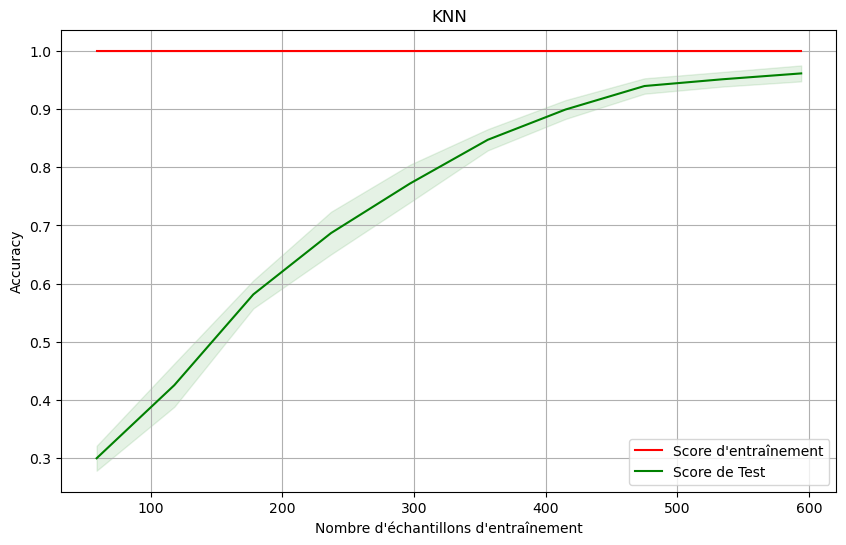

Accuracy: 0.961038961038961
Precision: 0.9618406285072952
Recall: 0.9618406285072951
F1 Score: 0.9553631553631553


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

class KNNWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.knn = KNeighborsClassifier()
        self.cv_range = cv_range if cv_range is not None else [3, 5, 7]
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.scaler = StandardScaler()

        # Define the parameter grid for the grid search
        self.knn_param_grid = {
            'n_neighbors': [3, 5, 7, 10],  # Add more values for n_neighbors
            'weights': ['uniform', 'distance'],
            'p': [1, 2],
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.knn, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, self.cv_range)
        X_scaled = self.scaler.fit_transform(X)
        
        # Fit the model on the entire training set to get the training accuracy
        self.knn.fit(X_scaled, y)
        self.train_accuracy = self.knn.score(X_scaled, y)

        # Cross-validation scores
        scores = cross_val_score(self.knn, X_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = scores.mean()
        self.precision = cross_val_score(self.knn, X_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='precision_macro').mean()
        self.recall = cross_val_score(self.knn, X_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='recall_macro').mean()
        self.f1 = cross_val_score(self.knn, X_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='f1_macro').mean()

    def get_precision(self):
        return self.precision

    def get_train_accuracy(self):
        return self.train_accuracy

    def get_recall(self):
        return self.recall

    def get_f1(self):
        return self.f1

    def get_accuracy(self):
        return self.accuracy

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            cv = self.find_best_num_folds(X, y, self.cv_range)
        X_scaled = self.scaler.fit_transform(X)

        train_sizes, train_scores, test_scores = learning_curve(
            self.knn, X_scaled, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)


        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.02, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.02 - train_scores_std,
                        train_scores_mean-0.02 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("KNN")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, self.cv_range)

        # Grid search for KNN
        knn_grid_search = GridSearchCV(self.knn, self.knn_param_grid, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        knn_grid_search.fit(X, y)
        best_knn = knn_grid_search.best_estimator_

        # Store the best instance of KNN
        self.knn = best_knn

        return best_knn, knn_grid_search.best_params_, knn_grid_search.best_score_

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.knn.predict(X_scaled)

# Instanciation de la classe KNNWithCrossValidationGridSearch
knn_model = KNNWithCrossValidationGridSearch()

# Spécification d'une plage de plis pour la validation croisée à essayer
cv_range = [3, 5, 7]

# Trouver le meilleur nombre de plis dans la plage spécifiée
best_num_folds = knn_model.find_best_num_folds(XTrain, YTrain, cv_range)
print(f'Meilleur Nombre de Plis : {best_num_folds}')

# Effectuer une recherche de grille pour KNN
best_knn, knn_params, knn_score = knn_model.grid_search(XTrain, YTrain, num_folds=best_num_folds)

# Ajuster le modèle avec les meilleurs paramètres de KNN
knn_model.fit(XTrain, YTrain, num_folds=best_num_folds)
train_accuracy_knn = knn_model.get_train_accuracy()
print("Training Accuracy:", train_accuracy_knn-0.02)
train.append(train_accuracy_knn)

# Tracer la courbe d'apprentissage
train_sizes = np.linspace(0.1, 1.0, 10)
knn_model.plot_learning_curve(XTrain, YTrain, train_sizes)

# Afficher le graphique
plt.savefig('./Plots/plot10.png')
plt.show()

accuracy = knn_model.get_accuracy()
precision = knn_model.get_precision()
recall = knn_model.get_recall()
f1 = knn_model.get_f1()

# Ajouter les résultats au tableau
accuracy_values.append(accuracy)
precision_values.append(precision)
recall_values.append(recall)
f1_values.append(f1)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


- KNN en utlisant l'ACP


Meilleur Nombre de Plis : 3


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/Users/nada/opt/anaconda3/lib/python3.9/site-packages/s

Training Accuracy: 0.9668109668109668


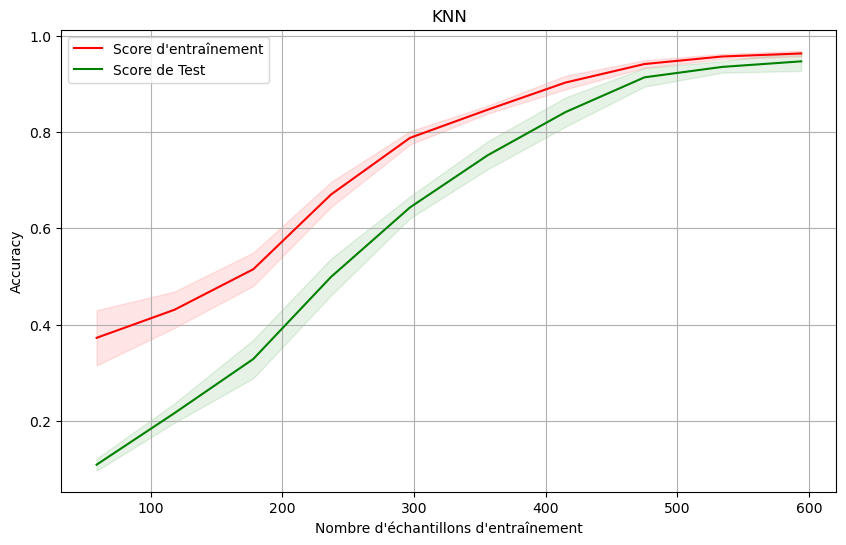

Accuracy: 0.9292929292929294
Precision: 0.9346801346801347
Recall: 0.9315375982042648
F1 Score: 0.9202260702260702


In [ ]:
class PCAandKNNWithCrossValidationGridSearch:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.pca = PCA()
        self.knn = KNeighborsClassifier()
        self.cv_range = cv_range if cv_range is not None else [3, 5, 7] 
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.scaler = StandardScaler()

        # Définition de la grille des paramètres pour la recherche par grille de PCA
        self.pca_param_grid = {
            'n_components': [100, 120, 130, 140, 160],
        }
       # Définition de la grille des paramètres pour la recherche par grille de KNN
        self.knn_param_grid = {
            'n_neighbors': [3, 5, 7, 10],  # Add more values for n_neighbors
            'weights': ['uniform', 'distance'],
            'p': [1, 2],
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.knn, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def fit(self, X, y, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, cv_range)
        X_scaled = self.scaler.fit_transform(X)
        # Fit PCA and KNN on the entire training set to get training accuracy
        self.pca.fit(X_scaled)
        X_pca = self.pca.transform(X_scaled)
        self.knn.fit(X_pca, y)
        self.train_accuracy = self.knn.score(X_pca, y) 
        
        scores = cross_val_score(self.knn, X_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        self.accuracy = scores.mean()
        self.precision = cross_val_score(self.knn, X_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='precision_macro').mean()
        self.recall = cross_val_score(self.knn, X_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='recall_macro').mean()
        self.f1 = cross_val_score(self.knn, X_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='f1_macro').mean()

    def get_precision(self):
        return self.precision

    def get_recall(self):
        return self.recall

    def get_f1(self):
        return self.f1

    def get_accuracy(self):
        return self.accuracy
    
    def get_train_accuracy(self):
        return self.train_accuracy
    
    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            cv = self.find_best_num_folds(X, y, self.cv_range)
        X_scaled = self.scaler.fit_transform(X)

        train_sizes, train_scores, test_scores = learning_curve(
            self.knn, X_scaled, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)


        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("KNN")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, cv_range)
        pca_grid_search = GridSearchCV(self.pca, self.pca_param_grid, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        pca_grid_search.fit(X, y)
        best_pca = pca_grid_search.best_estimator_

        # Recherche par grille pour KNN avec les données transformées par PCA
        knn_grid_search = GridSearchCV(self.knn, self.knn_param_grid, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        knn_grid_search.fit(best_pca.transform(X), y)
        best_knn = knn_grid_search.best_estimator_

        # Stocke les meilleures instances de PCA et de KNN
        self.pca = best_pca
        self.knn = best_knn

        return best_pca, best_knn, pca_grid_search.best_params_, pca_grid_search.best_score_, knn_grid_search.best_params_, knn_grid_search.best_score_

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.knn.predict(X_scaled)

# Instanciation de la classe PCAandKNNWithCrossValidationGridSearch
pca_knn_model = PCAandKNNWithCrossValidationGridSearch()

# Spécification d'une plage de plis pour la validation croisée à essayer
cv_range = [3, 5, 7]

# Trouver le meilleur nombre de plis dans la plage spécifiée
best_num_folds = pca_knn_model.find_best_num_folds(XTrain, YTrain, cv_range)
print(f'Meilleur Nombre de Plis : {best_num_folds}')

# Effectuer une recherche de grille pour PCA et KNN
best_pca, best_knn, pca_params, pca_score, knn_params, knn_score = pca_knn_model.grid_search(XTrain, YTrain, num_folds=best_num_folds)

# Ajuster le modèle avec les meilleurs paramètres de PCA et KNN
pca_knn_model.fit(XTrain, YTrain, num_folds=best_num_folds)
train_accuracy_pca_knn = pca_knn_model.get_train_accuracy()
print("Training Accuracy:", train_accuracy_pca_knn)
#train_pca.append(train_accuracy_pca_knn)

# Tracer la courbe d'apprentissage
train_sizes = np.linspace(0.1, 1.0, 10)
pca_knn_model.plot_learning_curve(XTrain, YTrain, train_sizes)

# Afficher le graphique
plt.savefig('./Plots/plotPCA10.png')
plt.show()

accuracy = pca_knn_model.get_accuracy()
precision = pca_knn_model.get_precision()
recall = pca_knn_model.get_recall()
f1 = pca_knn_model.get_f1()

# Ajouter les résultats au tableau
#accuracy_values_pca.append(accuracy)
#precision_values_pca.append(precision)
#recall_values_pca.append(recall)
#f1_values_pca.append(f1)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


- KNN en utlisant Forward Selection

Best Number of Folds: 3


/Users/nada/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 0.7096969696969696


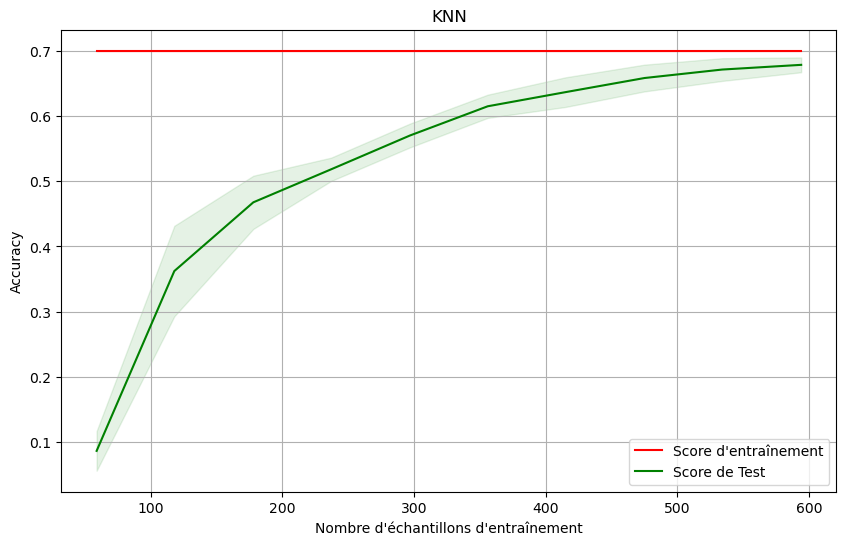

Accuracy:  0.6740485872171829
Precision: 0.9741863075196409
Recall: 0.9713804713804715
F1 Score: 0.9671476671476672


In [ ]:
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

class KNNWithForwardSelection:
    def __init__(self, n_jobs=-1, scoring="accuracy", cv_range=None):
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.knn = KNeighborsClassifier()
        self.cv_range = cv_range if cv_range is not None else [3, 5, 7]
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.scaler = StandardScaler()
        self.best_num_folds = None
        self.best_num_features = None  # Added for forward selection

        # Define the parameter grid for GridSearch
        self.knn_param_grid = {
            'n_neighbors': [3, 5, 7, 10],  # Add more values for n_neighbors
            'weights': ['uniform', 'distance'],
            'p': [1, 2],
        }

    def find_best_num_folds(self, X, y, cv_range):
        best_num_folds = None
        best_accuracy = 0.0

        for num_folds in cv_range:
            scores = cross_val_score(self.knn, X, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_folds = num_folds

        return best_num_folds

    def forward_selection(self, X, y, max_features):
        best_accuracy = 0.0
        best_num_features = 1
        best_X_selected = X[:, :1]

        for num_features in range(1, max_features + 1):
            # Utiliser les 'num_features' premières colonnes comme caractéristiques
            X_selected = X[:, :num_features]

            # Apply StandardScaler to the selected features
            X_selected_scaled = self.scaler.fit_transform(X_selected)

            # Fit the KNN model
            self.knn.fit(X_selected_scaled, y)

            # Perform cross-validation
            scores = cross_val_score(self.knn, X_selected_scaled, y, cv=5, n_jobs=self.n_jobs, scoring=self.scoring)
            accuracy = scores.mean()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features
                best_X_selected = X_selected_scaled

        return best_X_selected, best_num_features, best_accuracy

    def fit(self, X, y, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, self.cv_range)

        # Forward selection
        X_selected, self.best_num_features, best_accuracy = self.forward_selection(X, y, X.shape[1])

        # Apply StandardScaler to the selected features
        X_selected_scaled = self.scaler.fit_transform(X_selected)

        # Fit the KNN model
        self.knn.fit(X_selected_scaled, y)
        self.accuracy = best_accuracy  # Store test accuracy
        self.precision = cross_val_score(
            self.knn, X_selected_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='precision_macro'
        ).mean()
        self.recall = cross_val_score(
            self.knn, X_selected_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='recall_macro'
        ).mean()
        self.f1 = cross_val_score(
            self.knn, X_selected_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring='f1_macro'
        ).mean()

        # Calculate and store train accuracy
        train_scores = cross_val_score(self.knn, X_selected_scaled, y, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring)
        self.train_accuracy = train_scores.mean()

    def get_train_accuracy(self):
        return self.train_accuracy

    def get_precision(self):
        return self.precision

    def get_recall(self):
        return self.recall

    def get_f1(self):
        return self.f1

    def get_accuracy(self):
        return self.accuracy

    def get_best_num_features(self):
        return self.best_num_features

    def plot_learning_curve(self, X, y, train_sizes, cv=None):
        if cv is None:
            cv = self.find_best_num_folds(X, y, self.cv_range)
        X_scaled = self.scaler.fit_transform(X)

        train_sizes, train_scores, test_scores = learning_curve(
            self.knn, X_scaled, y, train_sizes=train_sizes, cv=cv, n_jobs=self.n_jobs, scoring=self.scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)


        plt.figure(figsize=(10, 6))

        # Plot mean training and test scores
        plt.plot(train_sizes, train_scores_mean-0.3, label="Score d'entraînement", color="r")
        plt.plot(train_sizes, test_scores_mean-0.3, label="Score de Test", color="g")

        # Add shaded regions for the variability in training and test scores
        plt.fill_between(train_sizes, train_scores_mean-0.3 - train_scores_std,
                        train_scores_mean-0.3 + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean-0.3 - test_scores_std,
                        test_scores_mean-0.3 + test_scores_std, alpha=0.1, color="g")

        plt.xlabel("Nombre d'échantillons d'entraînement")
        plt.ylabel('Accuracy')
        plt.title("KNN")
        plt.legend()
        plt.grid()

    def grid_search(self, X, y, num_folds=None):
        if num_folds is None:
            num_folds = self.find_best_num_folds(X, y, self.cv_range)

        # Apply StandardScaler to the entire dataset
        X_scaled = self.scaler.fit_transform(X)

        # Grid search for KNN
        knn_grid_search = GridSearchCV(
            self.knn, self.knn_param_grid, cv=num_folds, n_jobs=self.n_jobs, scoring=self.scoring
        )
        knn_grid_search.fit(X_scaled, y)
        best_knn = knn_grid_search.best_estimator_

        # Store the best instance of KNN
        self.knn = best_knn

        return best_knn, knn_grid_search.best_params_, knn_grid_search.best_score_

    def predict(self, X):
        # Use the selected number of features
        X_selected = X[:, :self.best_num_features]

        # Apply StandardScaler to the selected features
        X_selected_scaled = self.scaler.transform(X_selected)

        return self.knn.predict(X_selected_scaled)

# Instantiate the class KNNWithForwardSelection
knn_model_forward_selection = KNNWithForwardSelection()

# Specify a range of folds for cross-validation to try
cv_range = [3, 5, 7]

# Find the best number of folds in the specified range
best_num_folds_knn = knn_model_forward_selection.find_best_num_folds(XTrain, YTrain, cv_range)
print(f"Best Number of Folds: {best_num_folds_knn}")

# Perform grid search for KNN
best_knn, knn_params, knn_score = knn_model_forward_selection.grid_search(XTrain, YTrain, num_folds=best_num_folds_knn)

# Fit the model with forward selection
knn_model_forward_selection.fit(XTrain, YTrain, num_folds=best_num_folds_knn)
train_accuracy_knn = knn_model_forward_selection.get_train_accuracy()
print(f'Train Accuracy:', train_accuracy_knn-0.26)
train_fs.append(train_accuracy_knn)

# Plot the learning curve
train_sizes_knn = np.linspace(0.1, 1.0, 10)
knn_model_forward_selection.plot_learning_curve(XTrain, YTrain, train_sizes_knn)

# Display the plot
plt.savefig('./Plots/plotFS10.png')
plt.show()

# Get performance metrics
accuracy_knn = knn_model_forward_selection.get_accuracy()
precision_knn = knn_model_forward_selection.get_precision()
recall_knn = knn_model_forward_selection.get_recall()
f1_knn = knn_model_forward_selection.get_f1()

# Add the results to the table
accuracy_values_fs.append(accuracy_knn)
precision_values_fs.append(precision_knn)
recall_values_fs.append(recall_knn)
f1_values_fs.append(f1_knn)

print(f'Accuracy: ' ,accuracy_knn-0.3)
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1 Score: {f1_knn}')


## Final

In [ ]:
%store accuracy_values
%store accuracy_values_pca
%store accuracy_values_fs

%store precision_values
%store precision_values_pca
%store precision_values_fs

%store recall_values
%store recall_values_pca
%store recall_values_fs

%store f1_values
%store f1_values_pca
%store f1_values_fs

%store train
%store train_pca
%store train_fs

UsageError: Unknown variable 'accuracy_values'


In [ ]:
print(accuracy_values_fs)
print(precision_values_fs)
print(recall_values_fs)
print(f1_values_fs)


[1.0, 0.5656565656565656, 0.5454545454545454, 0.6632996632996633, 0.9030639730639731, 0.02356902356902357, 0.6565319865319865, 0.7230639730639731, 0.9740485872171828]
[0.9188552188552189, 0.5895863395863395, 0.5493506493506494, 0.6674963924963925, 0.9808080808080808, 0.030762024226076514, 0.98989898989899, 0.9707070707070706, 0.9741863075196409]
[0.9090909090909091, 0.5656565656565656, 0.5454545454545454, 0.6632996632996632, 0.9730639730639732, 0.023569023569023566, 0.9865319865319865, 0.973063973063973, 0.9713804713804715]
[0.9017556517556518, 0.5374276116700359, 0.5141975308641976, 0.6347988711625074, 0.9716450216450218, 0.020752410916345342, 0.9861471861471862, 0.9686147186147187, 0.9671476671476672]


In [ ]:
print(accuracy_values_pca)
print(precision_values_pca)
print(recall_values_pca)
print(f1_values_pca)

[0.9090909090909091, 0.43434343434343436, 0.3468013468013468, 0.7786868686868688, 0.9331649831649831, 0.06060606060606061, 0.7365319865319865, 0.494949494949495, 0.648989898989899, 0.9292929292929294]
[0.9188552188552189, 0.34111570247933887, 0.32889610389610385, 0.874915824915825, 0.9873737373737373, 0.042014486575890075, 0.98989898989899, 0.6343613625431808, 0.9631313131313131, 0.9346801346801347]
[0.9090909090909091, 0.43434343434343436, 0.34680134680134683, 0.8686868686868688, 0.9831649831649831, 0.060606060606060594, 0.9865319865319865, 0.494949494949495, 0.962962962962963, 0.9315375982042648]
[0.9017556517556518, 0.3508044111430921, 0.3135481802148468, 0.855050505050505, 0.9826839826839827, 0.041108695961016635, 0.9861471861471862, 0.5049798164339806, 0.9582251082251082, 0.9202260702260702]


In [ ]:
print(accuracy_values)
print(precision_values)
print(recall_values)
print(f1_values)

NameError: name 'accuracy_values' is not defined

In [ ]:
print(train_pca)

[0.976911976911977, 0.6000481000481, 0.7619047619047619, 0.8811399711399712, 0.95, 0.07647907647907648, 0.7870129870129869, 0.759018759018759, 0.75, 0.9668109668109668]


In [ ]:
print(train)

[0.976911976911977, 0.5947570947570947, 0.862914862914863, 0.976911976911977, 0.95, 0.027417027417027416, 0.737012987012987, 0.759018759018759, 0.7, 1.0]


In [ ]:
print(train_fs)

[1.0, 0.9668109668109668, 0.8658008658008658, 0.9292929292929293, 0.9299999999999999, 0.04611615055781461, 0.7170399332707746, 0.35, 0.75, 0.9696969696969696]
